In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import glob
import tqdm
from typing import List

sys.path.append("..")
from src import text_extraction, create_sentence_nace_code_similarities, analysis_functions

## Test retrieving the similarities for chunks in a pdf to the NACE Code

**Function:** pdf-> (chunk x code -> [-1,1])

**Parameters:** 

- pdf_path
- way of chunking the text (e.g. sentences, sliding window, or paragraphs)
- way of preprocessing (most is fixed for all reports)
    - similarity threshold of relevant chunks
    - length of irrelevant chunks

**Store analytics for each datapoint:**

- mean score for each class given a threshold

In [65]:
# Parameters: 

threshold_min_chunk_len = 10
cos_threshold = 0.4

result_path = f"../results/sentence_min_chunk_len_{threshold_min_chunk_len}_cos_thresh_{cos_threshold}_german_reports"

In [66]:
dataset_path = "../data/german_annual_reports"

In [67]:
nace_classes = pd.read_csv(os.path.join(dataset_path, "data.csv"))
report_to_nace_class = nace_classes.set_index('report').to_dict()[" NACE"]

In [68]:
reports_path = glob.glob(os.path.join(dataset_path, "*.pdf"))

In [69]:
def preprocess_report(pdf_path: str) -> List[str]:
    text = text_extraction.get_text_from_pdf(pdf_path)
    text = text_extraction.preprocess_text(text)
    chunks = text_extraction.get_sentences(text)
    chunks = list(dict.fromkeys(chunks))
    return chunks

### Test one run

In [70]:
def shorten_csv(df: pd.DataFrame) -> pd.DataFrame: 
    df = df.drop(columns="Embeddings")

    # For all columns except the first, keep only the 100 highest scores, set the rest to NaN
    for col in df.columns[1:]:
        top_100_idx = df[col].nlargest(100).index
        df.loc[~df.index.isin(top_100_idx), col] = np.nan
    df = df[df.iloc[:,1:].apply(lambda x: not pd.isna(x).all(), axis=1)]
    return df

In [71]:
report_path = reports_path[0]

In [72]:
chunks = preprocess_report(pdf_path=report_path)
# get similarities
df_similarities = create_sentence_nace_code_similarities.create_sentence_nace_code_similarities(chunks)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1056b6680>>
Traceback (most recent call last):
  File "/Users/hendrikweichel/miniconda3/envs/remedi/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


: 

: 

In [ ]:
# remove irrelevant chunks
df_similarities = df_similarities[df_similarities["Sentences"].apply(lambda x: len(x)>threshold_min_chunk_len)]

/Users/hendrikweichel/projects/NaceCodeClassification/nace_report_topic_analysis_3/test/../analysis_functions.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_temp.columns, rotation=90)
/Users/hendrikweichel/projects/NaceCodeClassification/nace_report_topic_analysis_3/test/../analysis_functions.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_temp.columns, rotation=90)


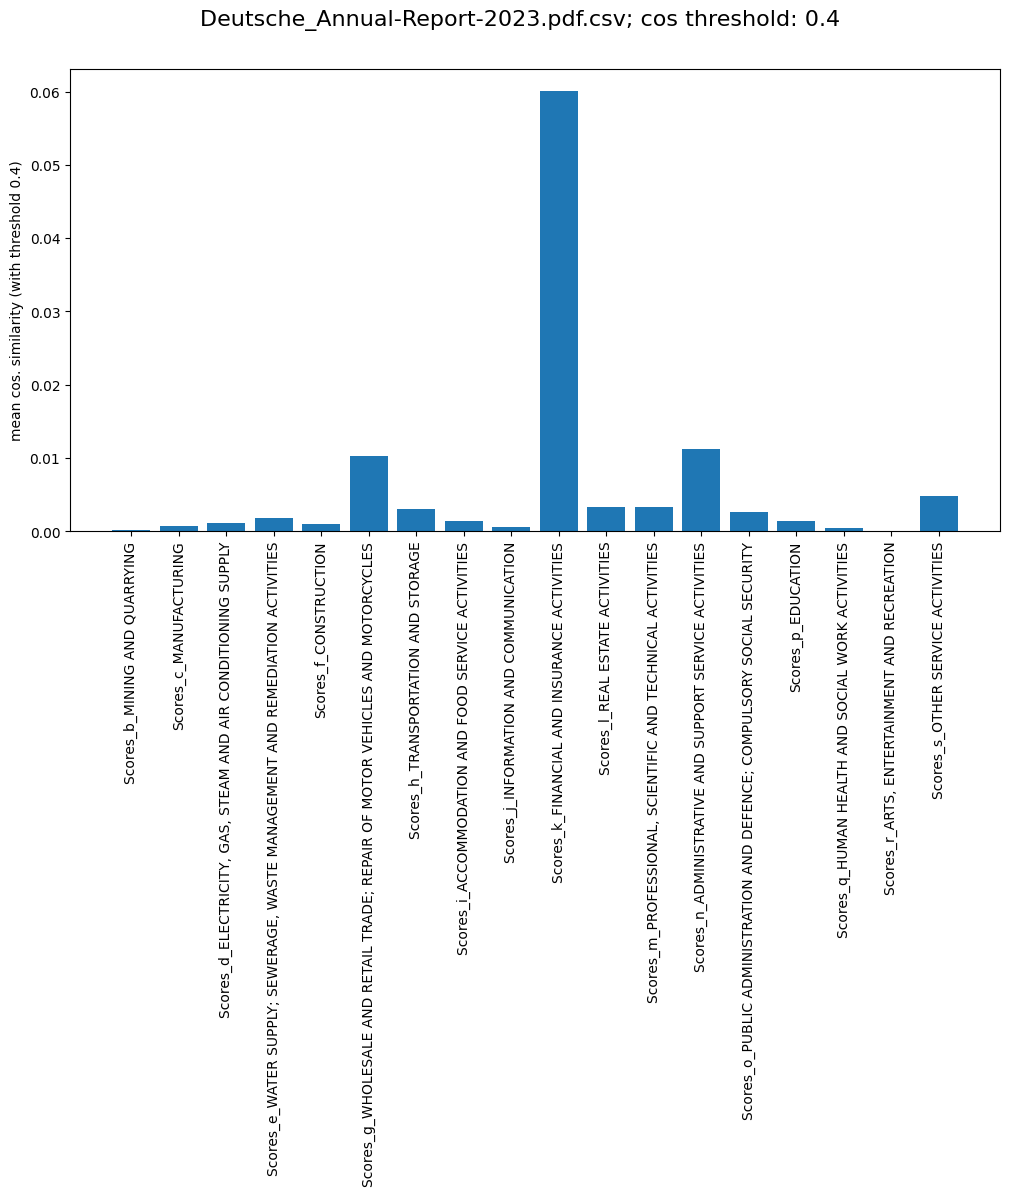

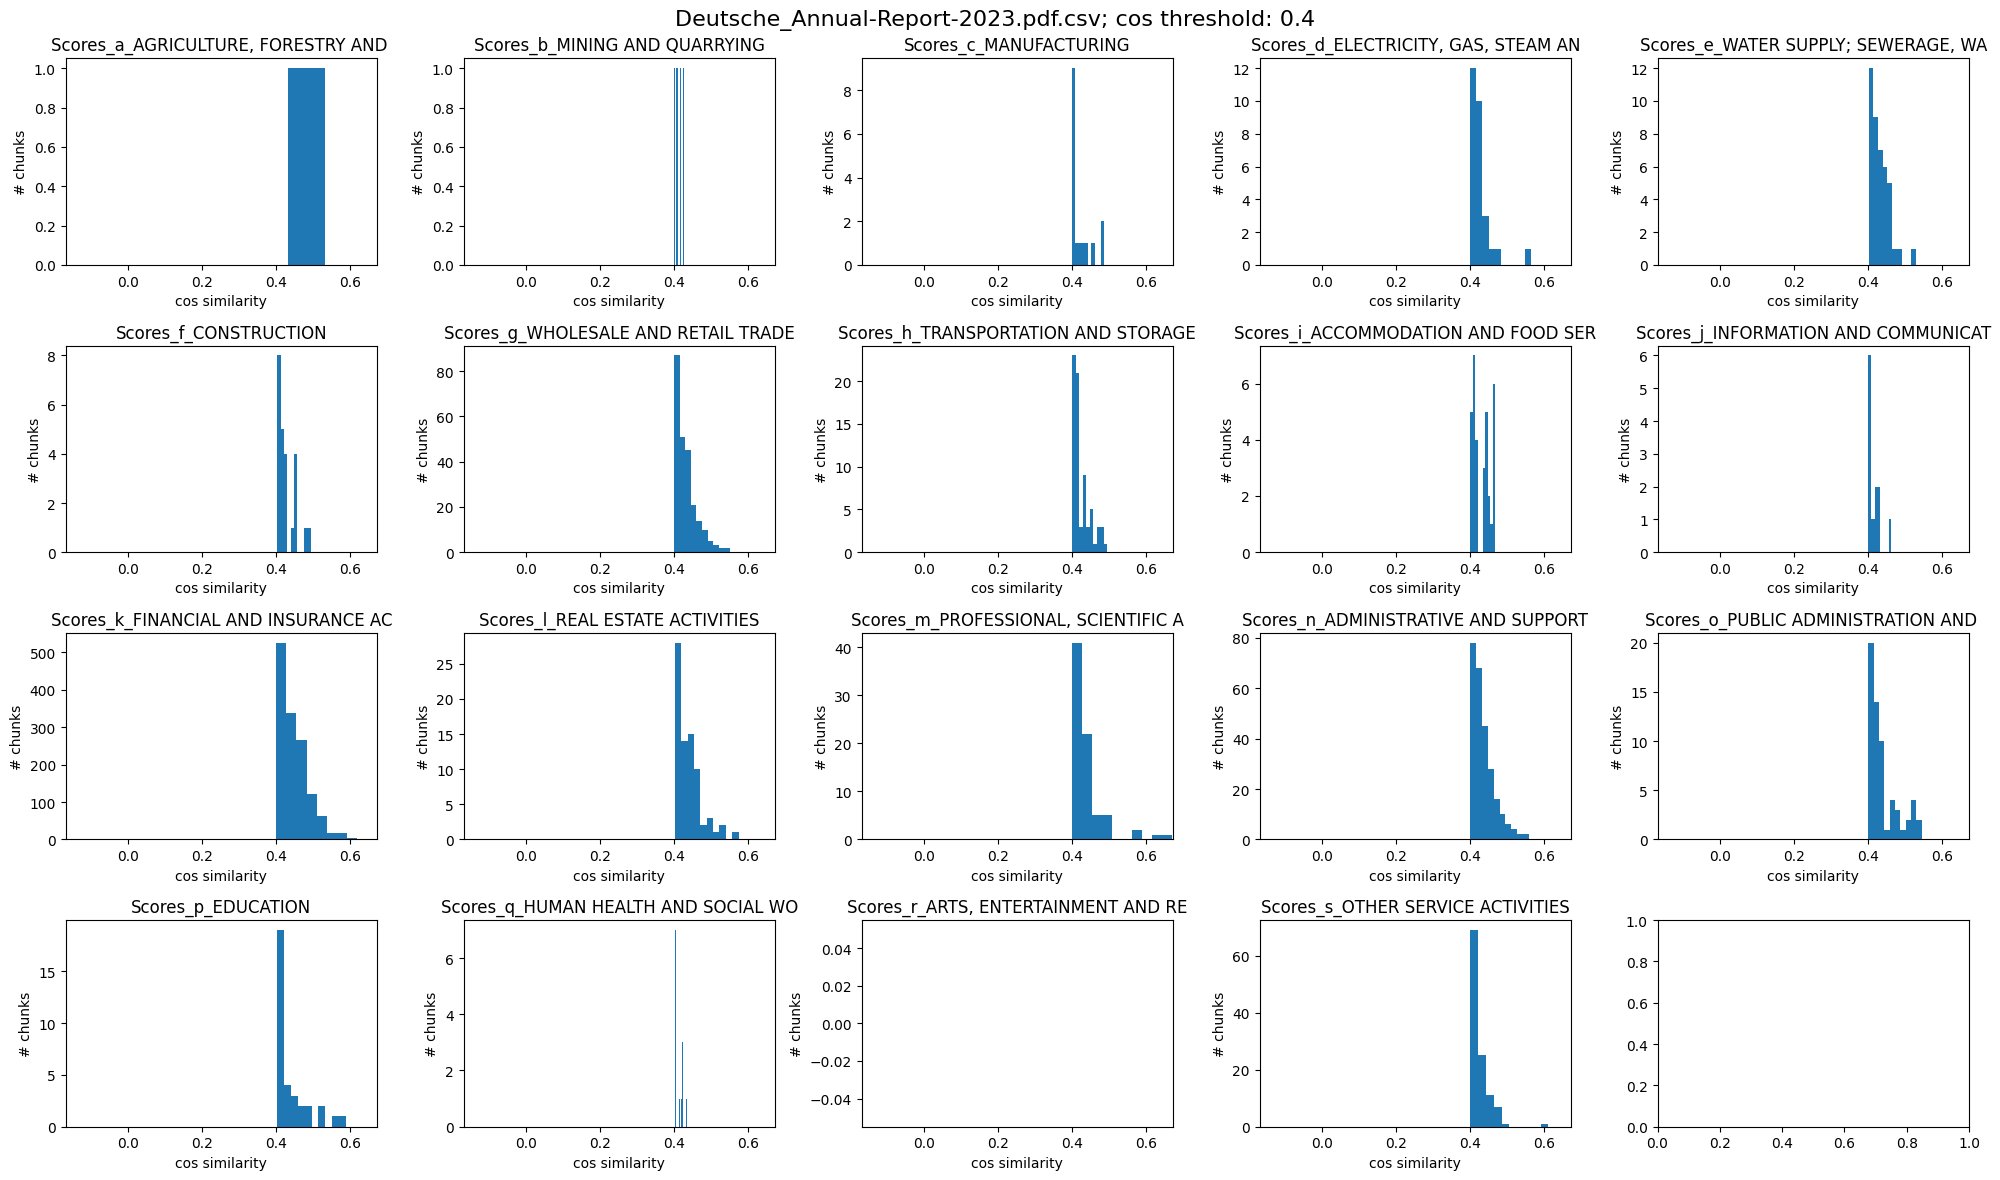

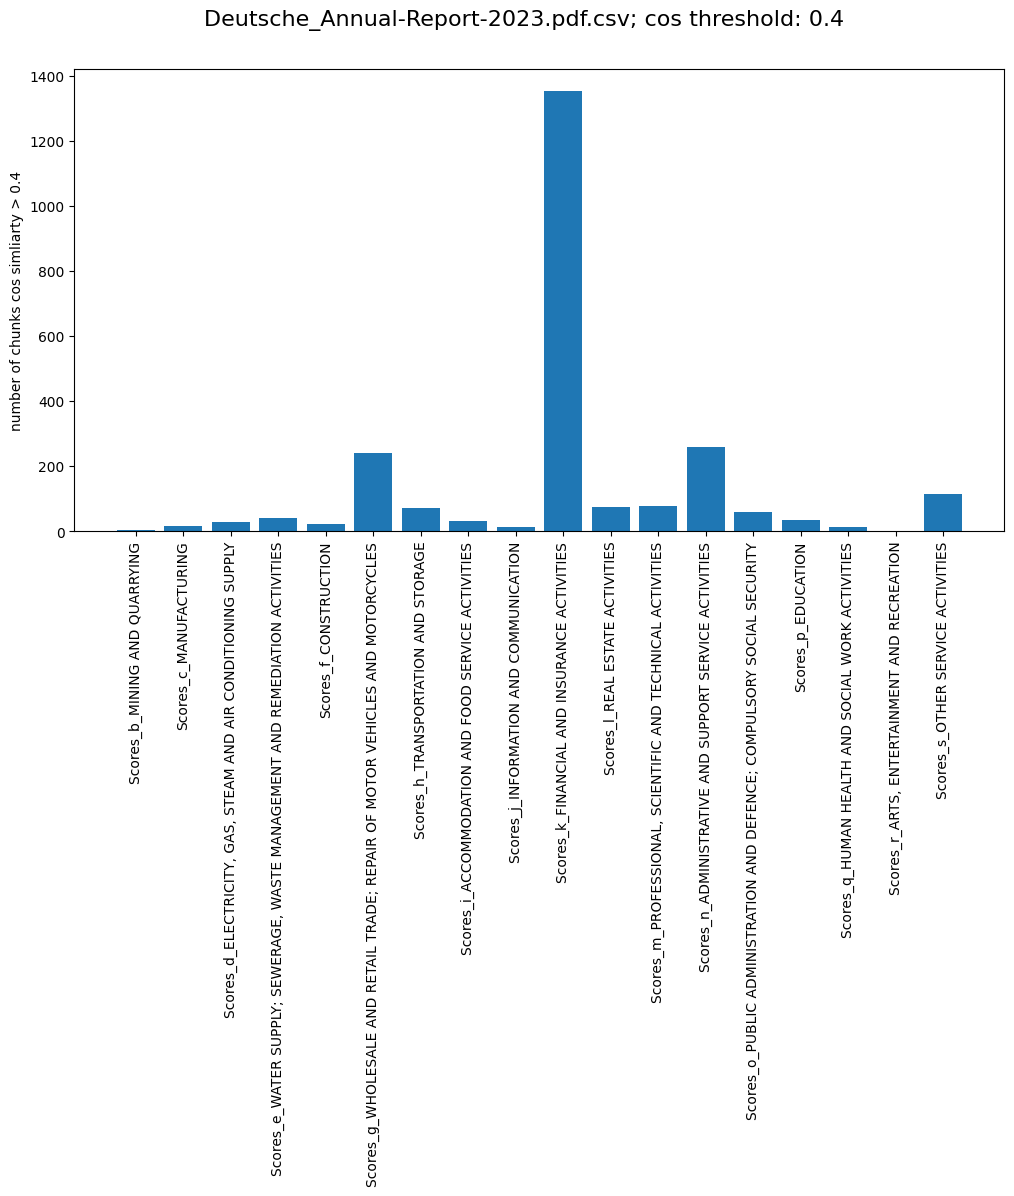

In [ ]:
# plot 
fig1 = analysis_functions.plot_mean_scores(df_similarities, cos_threshold=cos_threshold, NACE_codes="", name=os.path.basename(report_path))
fig2 = analysis_functions.plot_similarity_distributions(df_similarities, cos_threshold=cos_threshold, NACE_codes="", name=os.path.basename(report_path))
fig3 = analysis_functions.plot_nbr_threshold(df_similarities, cos_threshold=cos_threshold, NACE_codes="", name=os.path.basename(report_path))    

In [ ]:
# create report folder 
os.makedirs(os.path.join(result_path, os.path.basename(report_path)), exist_ok=True)

# store the figures
fig1.savefig(os.path.join(result_path, os.path.basename(report_path), "mean_scores.png"), bbox_inches="tight")
fig2.savefig(os.path.join(result_path, os.path.basename(report_path), "similarity_distributions.png"), bbox_inches="tight")
fig3.savefig(os.path.join(result_path, os.path.basename(report_path), "nbr_threshold.png"), bbox_inches="tight")

In [ ]:
# remove duplicates
df_similarities = df_similarities.drop_duplicates(subset=["Sentences"])

In [ ]:
scores = [column for column in df_similarities.columns if "Scores" in column]

In [ ]:
# apply threshold on similarities
df_temp = df_similarities[scores][df_similarities[scores] > cos_threshold]   
df_temp = df_temp.fillna(0)

In [ ]:
df_temp.mean().sort_values(ascending=False)

Scores_k_FINANCIAL AND INSURANCE ACTIVITIES                                      0.063081
Scores_n_ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES                           0.011564
Scores_g_WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES    0.010649
Scores_s_OTHER SERVICE ACTIVITIES                                                0.004905
Scores_l_REAL ESTATE ACTIVITIES                                                  0.003556
Scores_m_PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES                       0.003469
Scores_h_TRANSPORTATION AND STORAGE                                              0.003039
Scores_o_PUBLIC ADMINISTRATION AND DEFENCE; COMPULSORY SOCIAL SECURITY           0.002823
Scores_e_WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND REMEDIATION ACTIVITIES     0.001884
Scores_i_ACCOMMODATION AND FOOD SERVICE ACTIVITIES                               0.001378
Scores_p_EDUCATION                                                               0.001288
Scores_d_E

In [ ]:
store_sentences_path = os.path.join(result_path, os.path.basename(report_path), "relevant_sentences_" + os.path.basename(report_path))
os.makedirs(store_sentences_path, exist_ok=True)

i = 1
# store the 100 most important chunks of the 5 most relevant sectors (shown with mean)
for sector in df_temp.mean().sort_values(ascending=False)[:5].index: 
    top_chunks = df_temp[sector].sort_values(ascending=False)[:100]
    top_chunks_text = "\n\n".join([f"Score {round(df_similarities.loc[idx][sector], 3)}\n"+ df_similarities.loc[idx]["Sentences"] for idx in top_chunks.index])
    top_chunks_text = sector + top_chunks_text

    with open(os.path.join(store_sentences_path, str(i) + "_" + sector + ".txt"), "w") as f:
        f.write(top_chunks_text) 

    i += 1

In [ ]:
df_short = shorten_csv(df_similarities)

In [ ]:
df_short.to_csv(os.path.join(result_path, os.path.basename(report_path), os.path.basename(report_path) + ".csv"))

## Loooooop

In [ ]:
for report_path in tqdm.tqdm(reports_path): 
    print(report_path)
    print(report_to_nace_class.get(os.path.basename(report_path)))

100%|██████████| 10/10 [00:00<00:00, 74104.31it/s]

../data/german_annual_reports/Deutsche_Annual-Report-2023.pdf
 K
../data/german_annual_reports/bayer-annual-report-2023-2.pdf
	C
../data/german_annual_reports/adidas-ar23.pdf
None
../data/german_annual_reports/mercedes-benz-annual-report-2023-incl-combined-management-report-mbg-ag-2.pdf
 C
../data/german_annual_reports/Siemens-Annual-Report-2023.pdf
	C
../data/german_annual_reports/thyssenkrupp-GB_2023-2024_EN_WEB.pdf
 B
../data/german_annual_reports/Zalando-SE_DE_241203_s.pdf
None
../data/german_annual_reports/heidelberg-materials_2023.pdf
 C
../data/german_annual_reports/rheinmetall-ag_2023.pdf
 C
../data/german_annual_reports/conti_annual-report-2023-data.pdf
 C


  0%|          | 0/10 [00:00<?, ?it/s]/Users/hendrikweichel/projects/NaceCodeClassification/nace_report_topic_analysis_3/test/../analysis_functions.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_temp.columns, rotation=90)
/Users/hendrikweichel/projects/NaceCodeClassification/nace_report_topic_analysis_3/test/../analysis_functions.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_temp.columns, rotation=90)
 10%|█         | 1/10 [01:09<10:23, 69.23s/it]/Users/hendrikweichel/projects/NaceCodeClassification/nace_report_topic_analysis_3/test/../analysis_functions.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_temp.columns, rotation=90)
/Users/hendrikweichel/projec

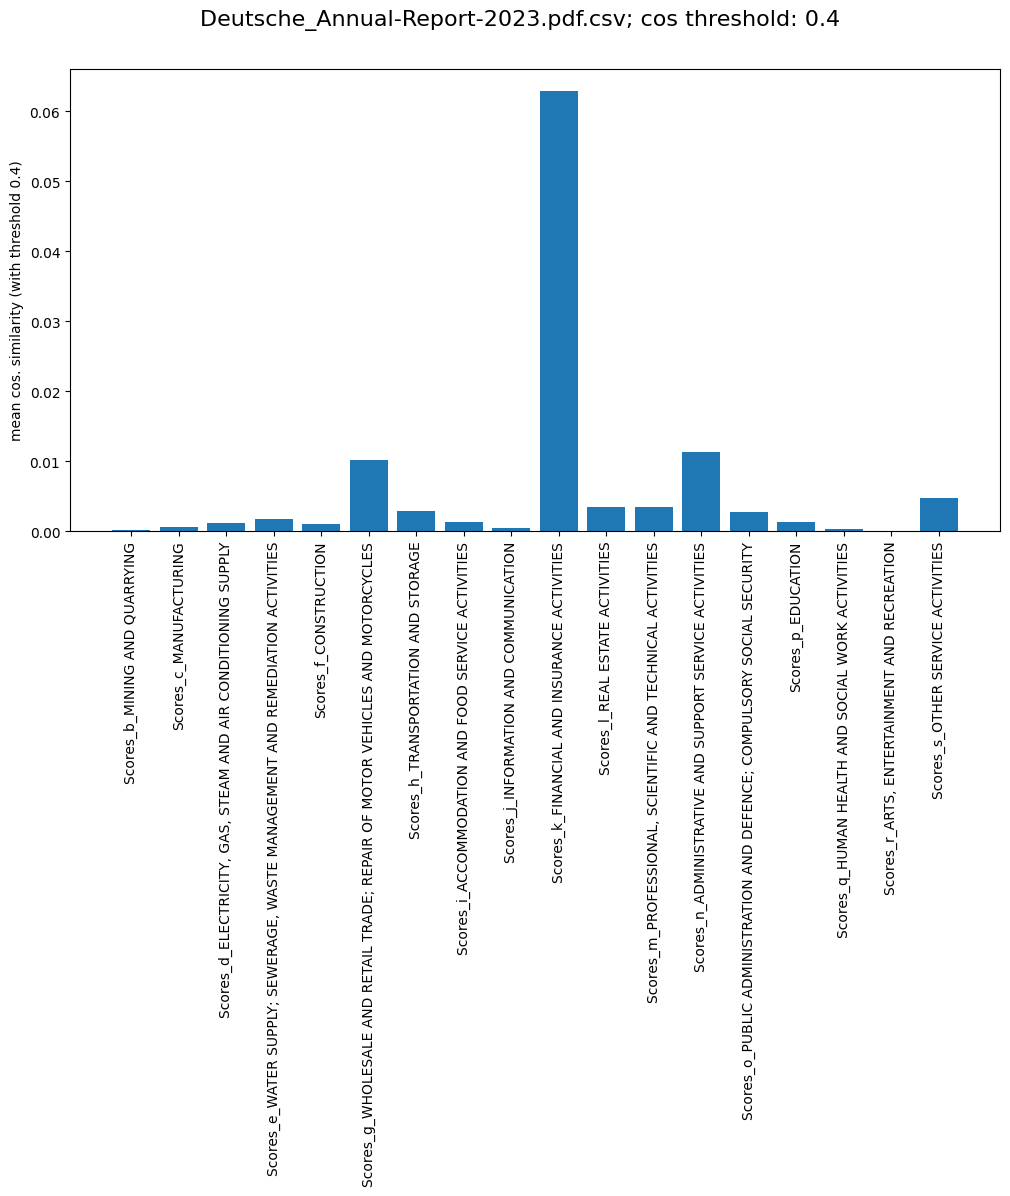

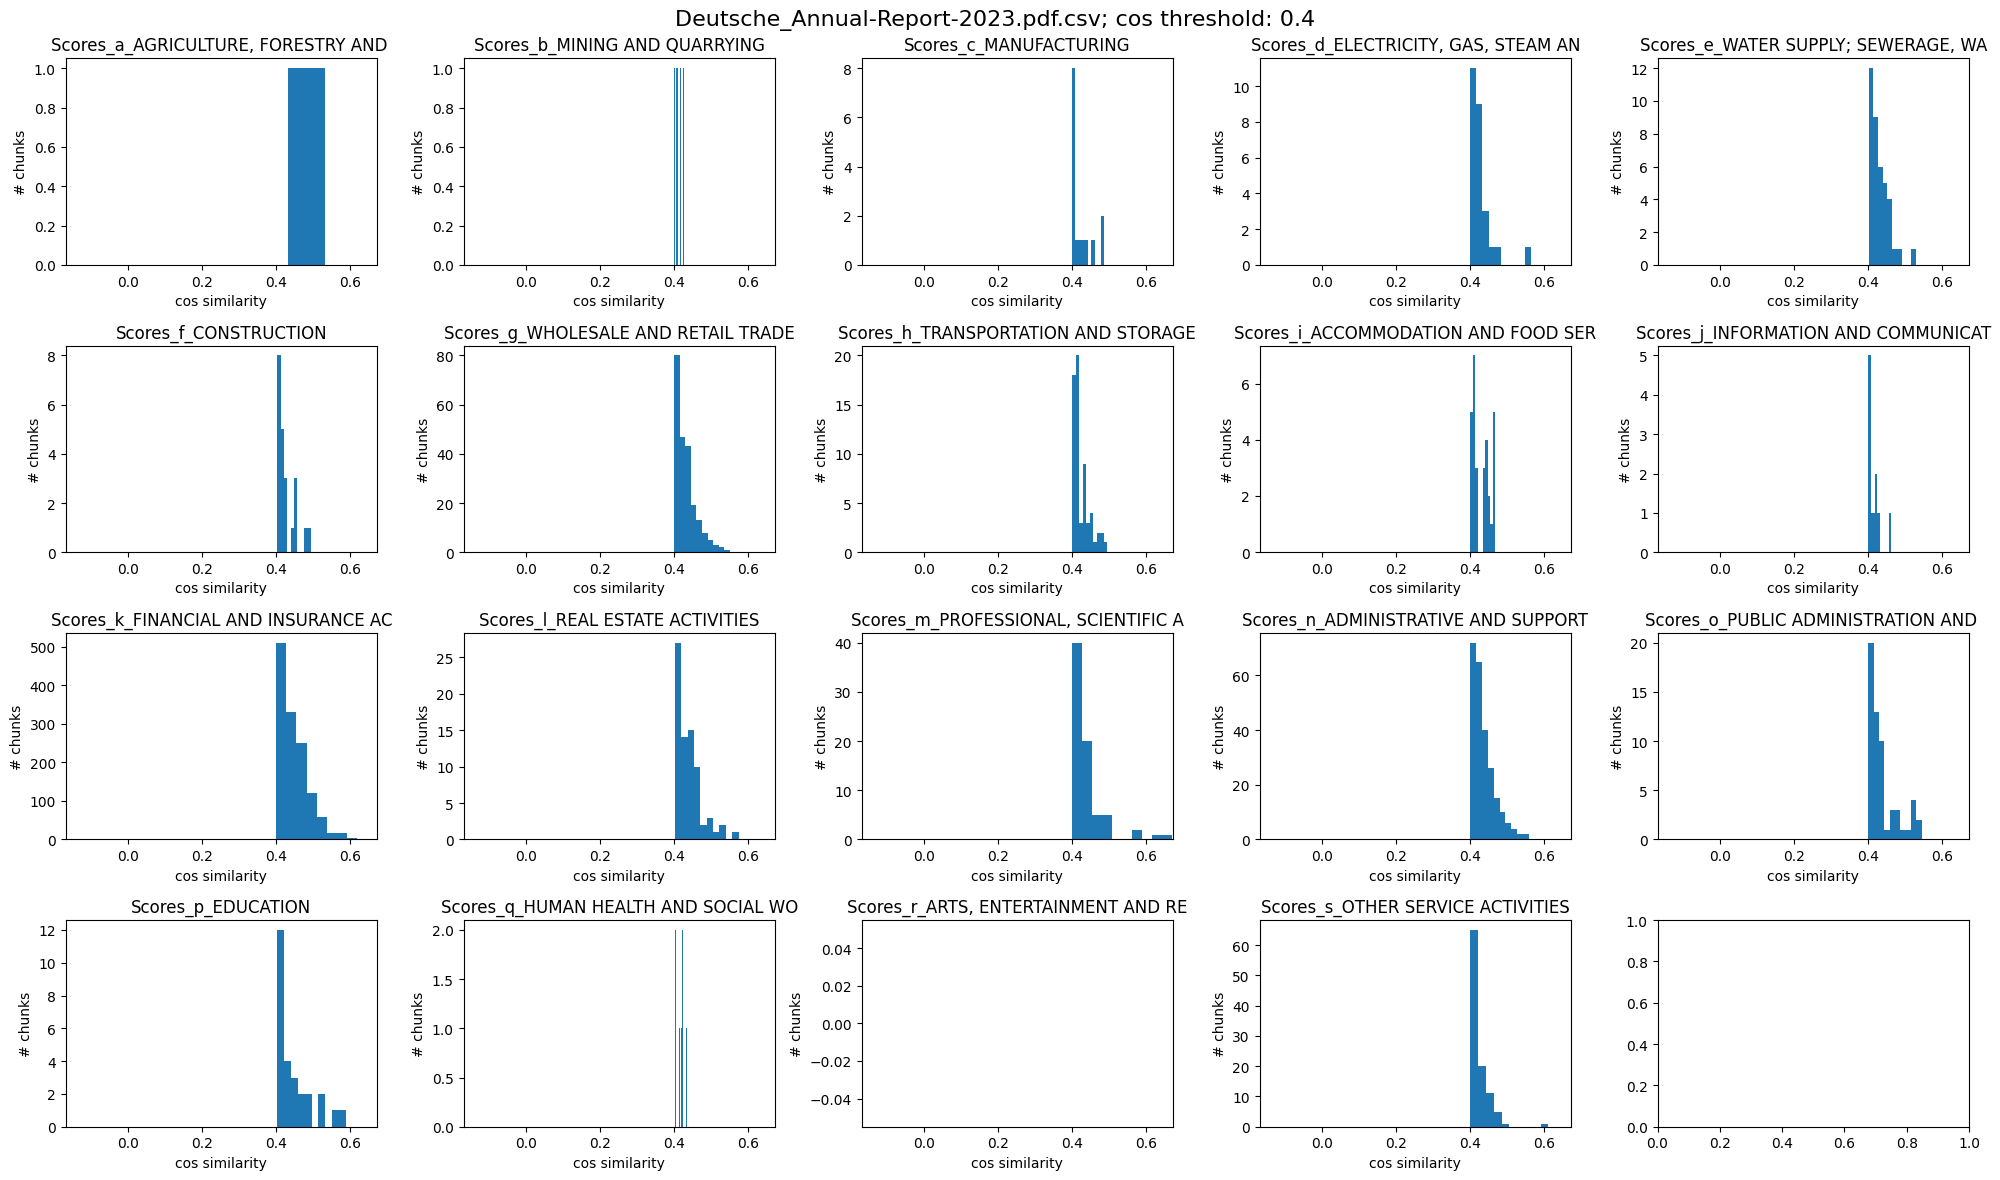

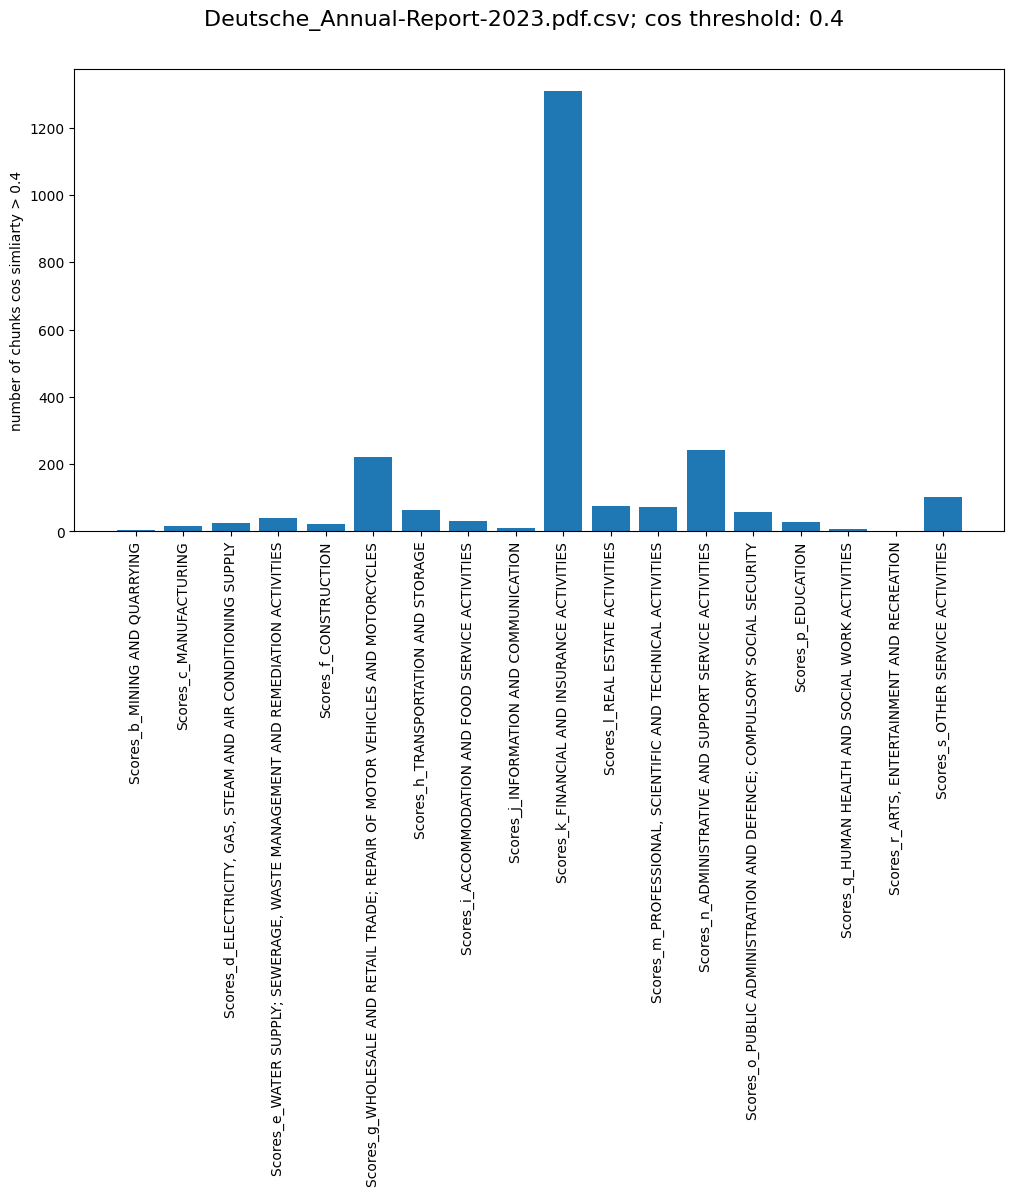

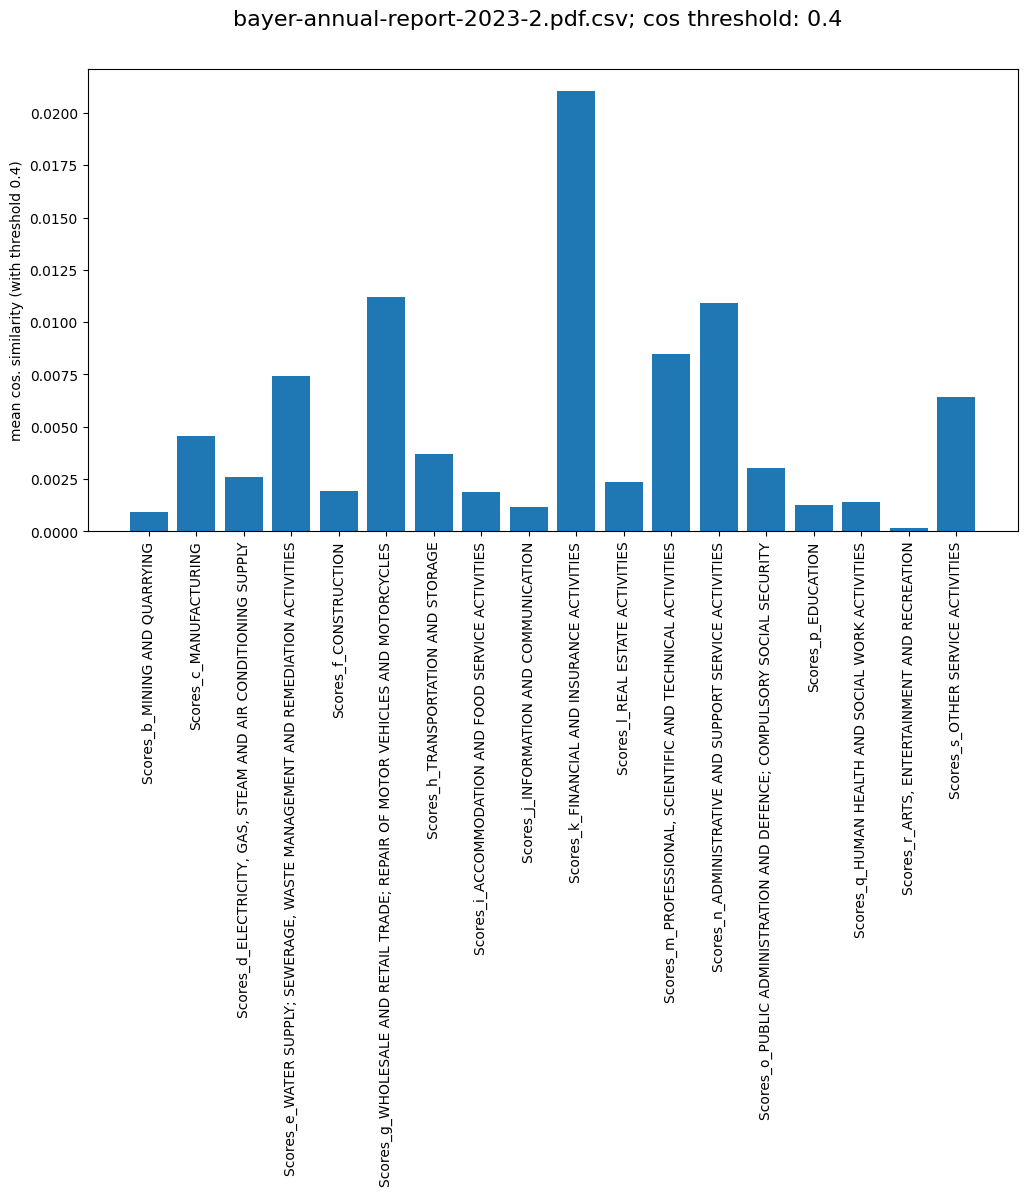

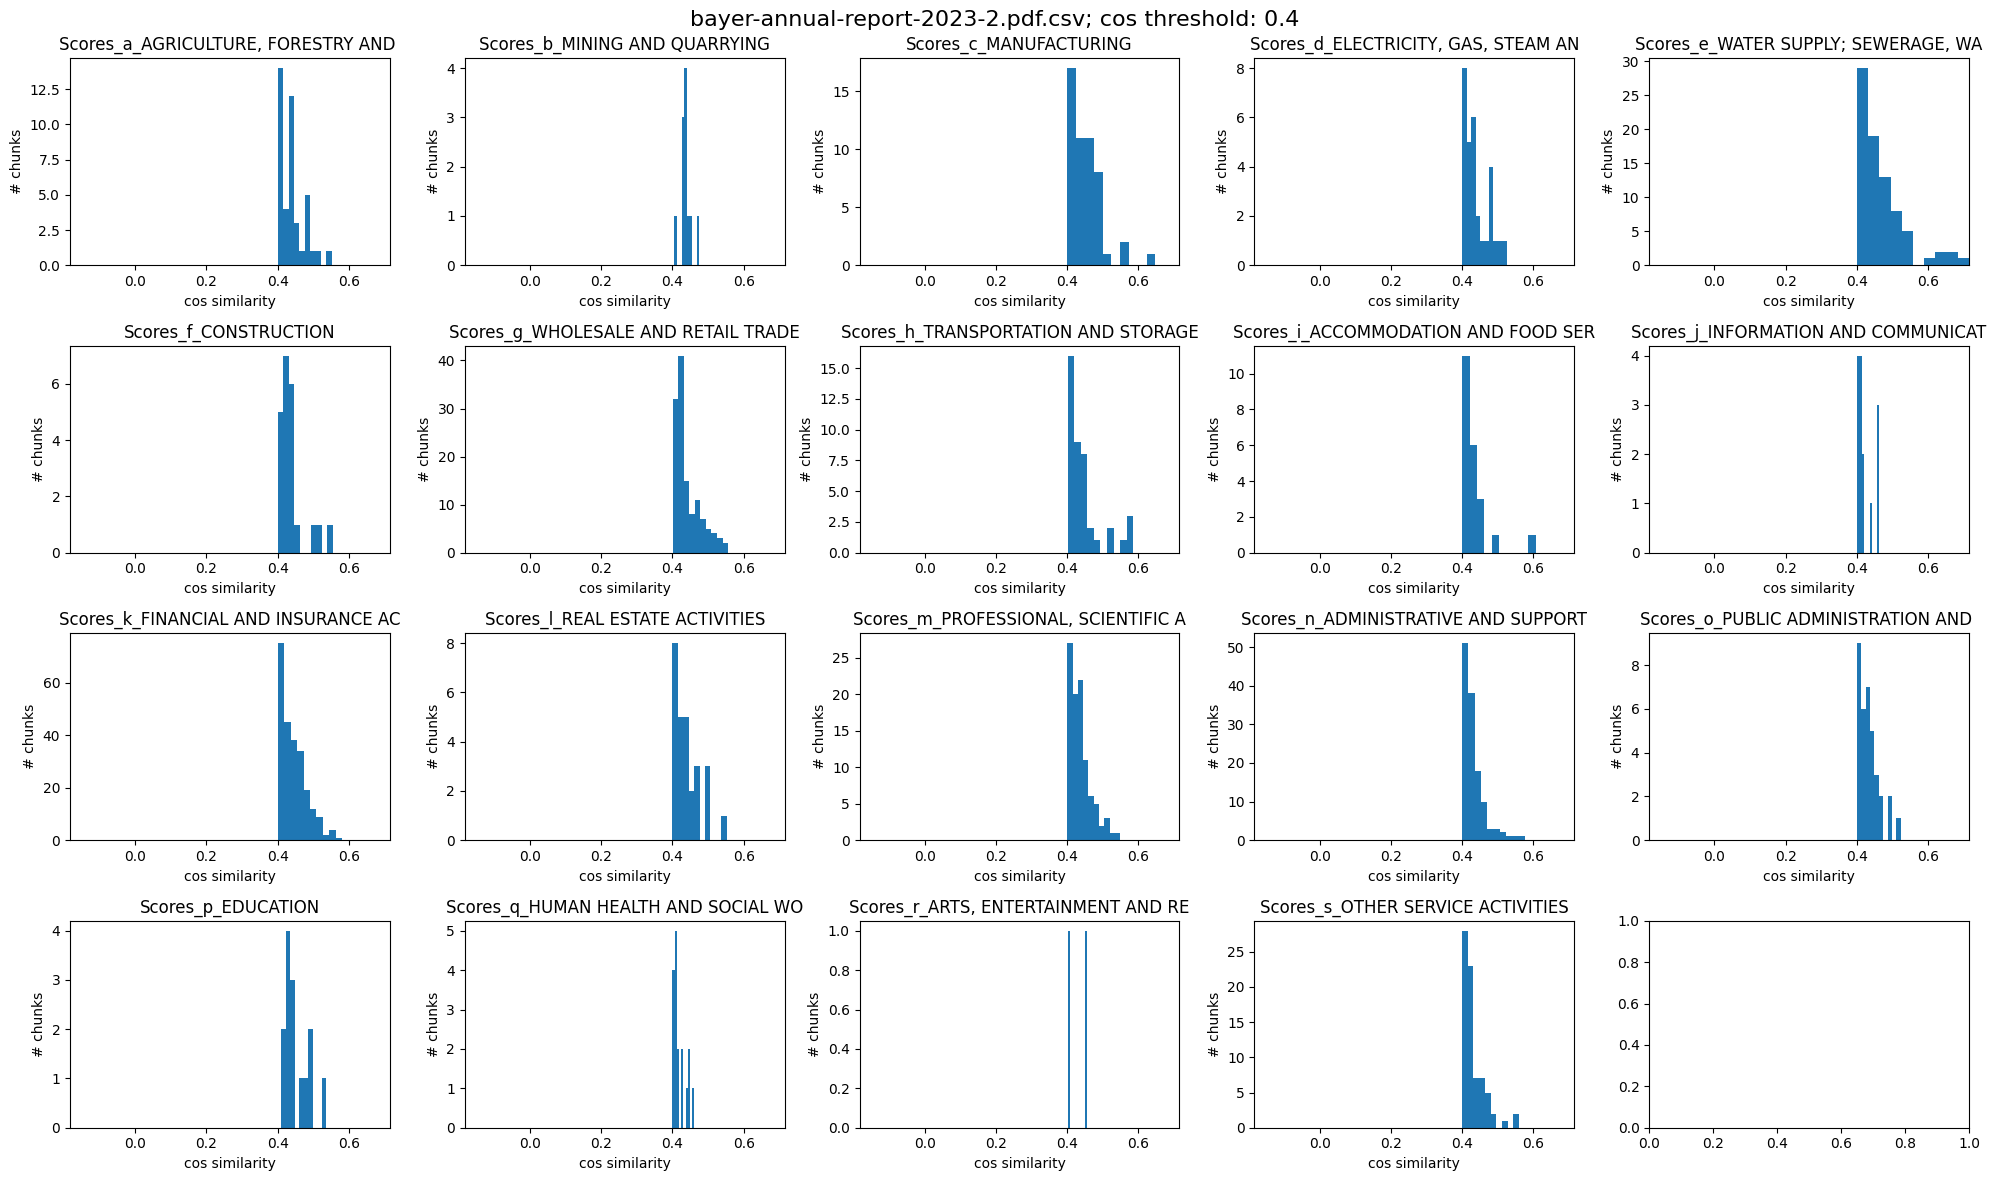

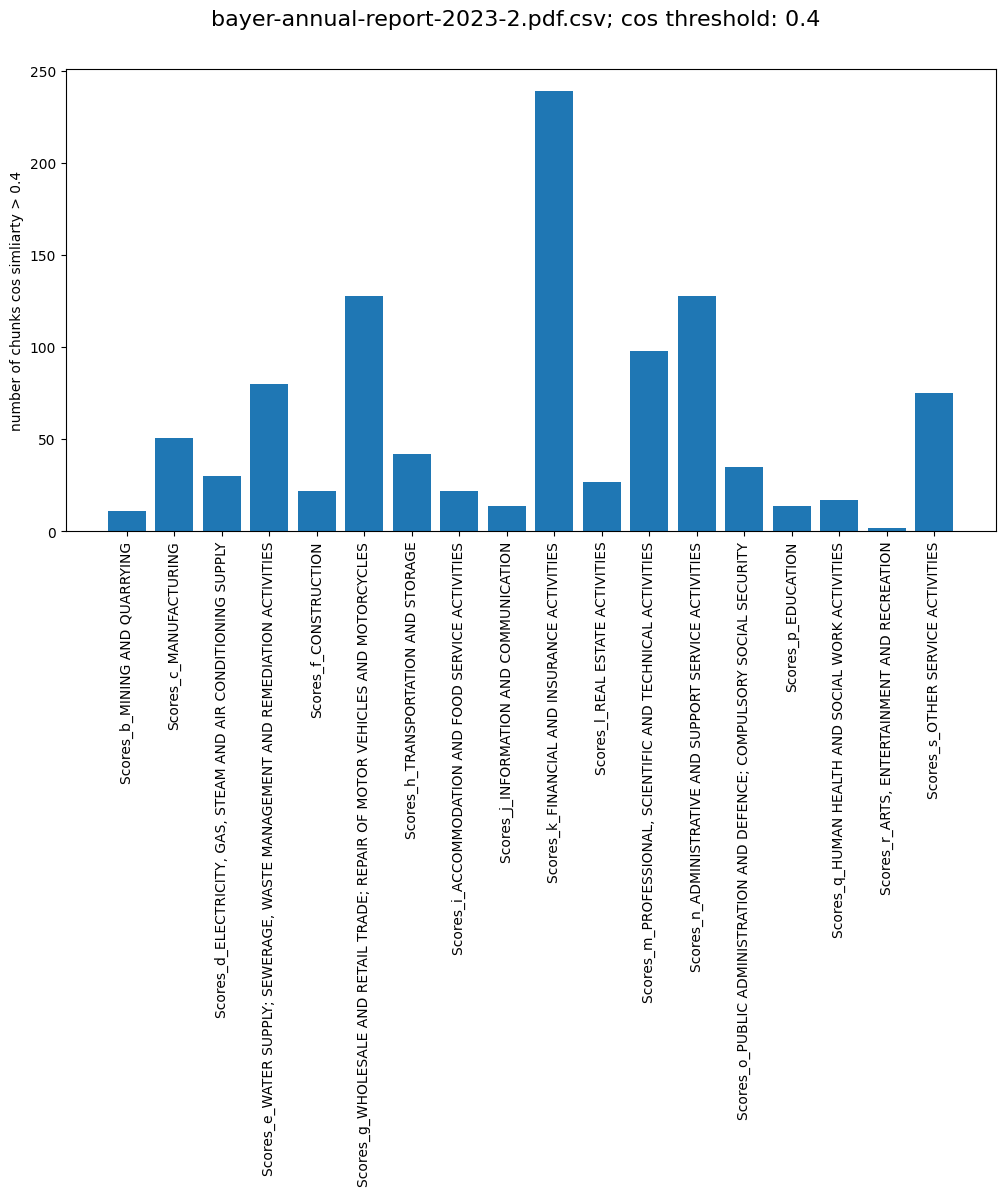

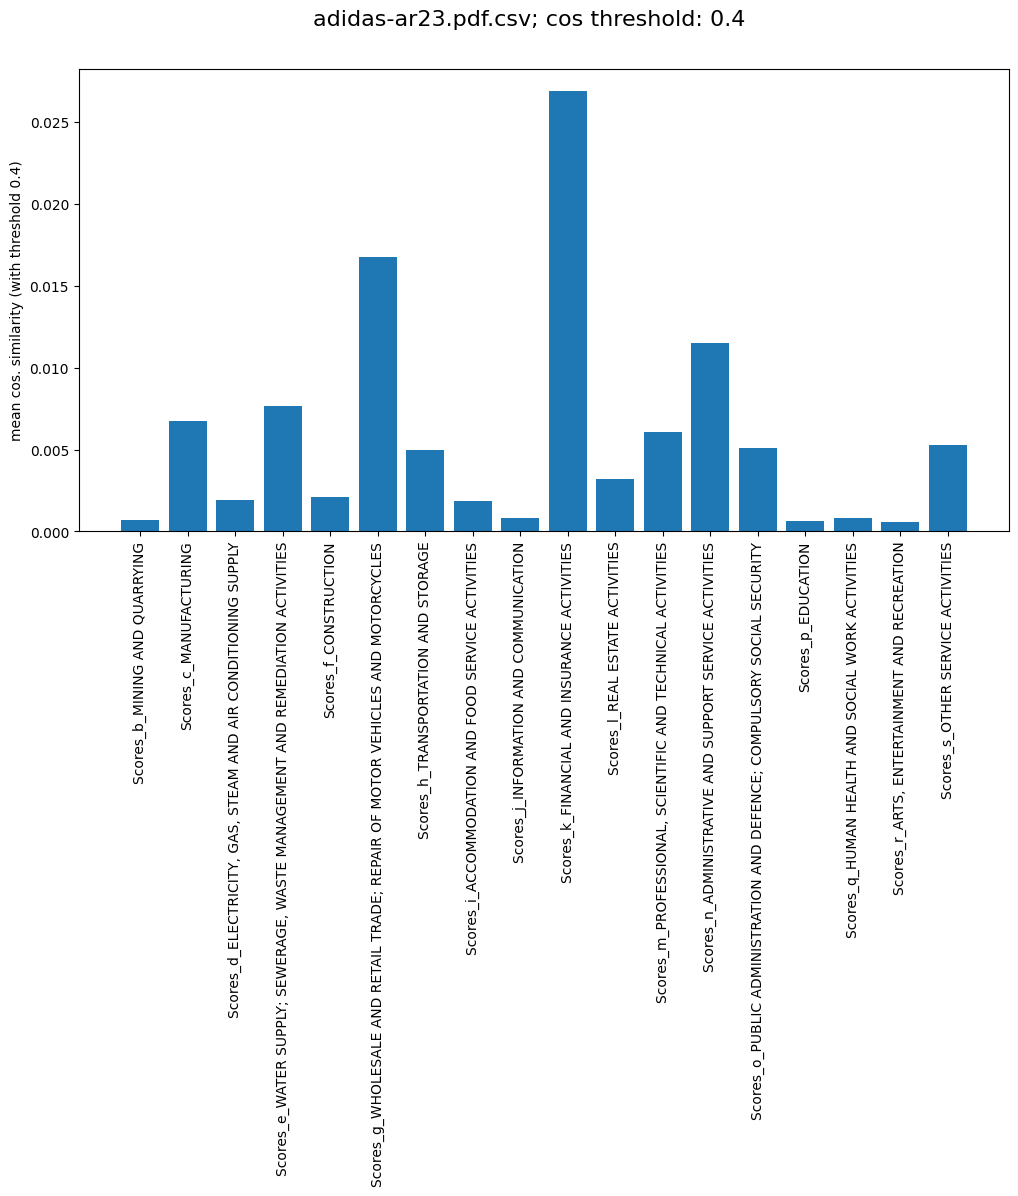

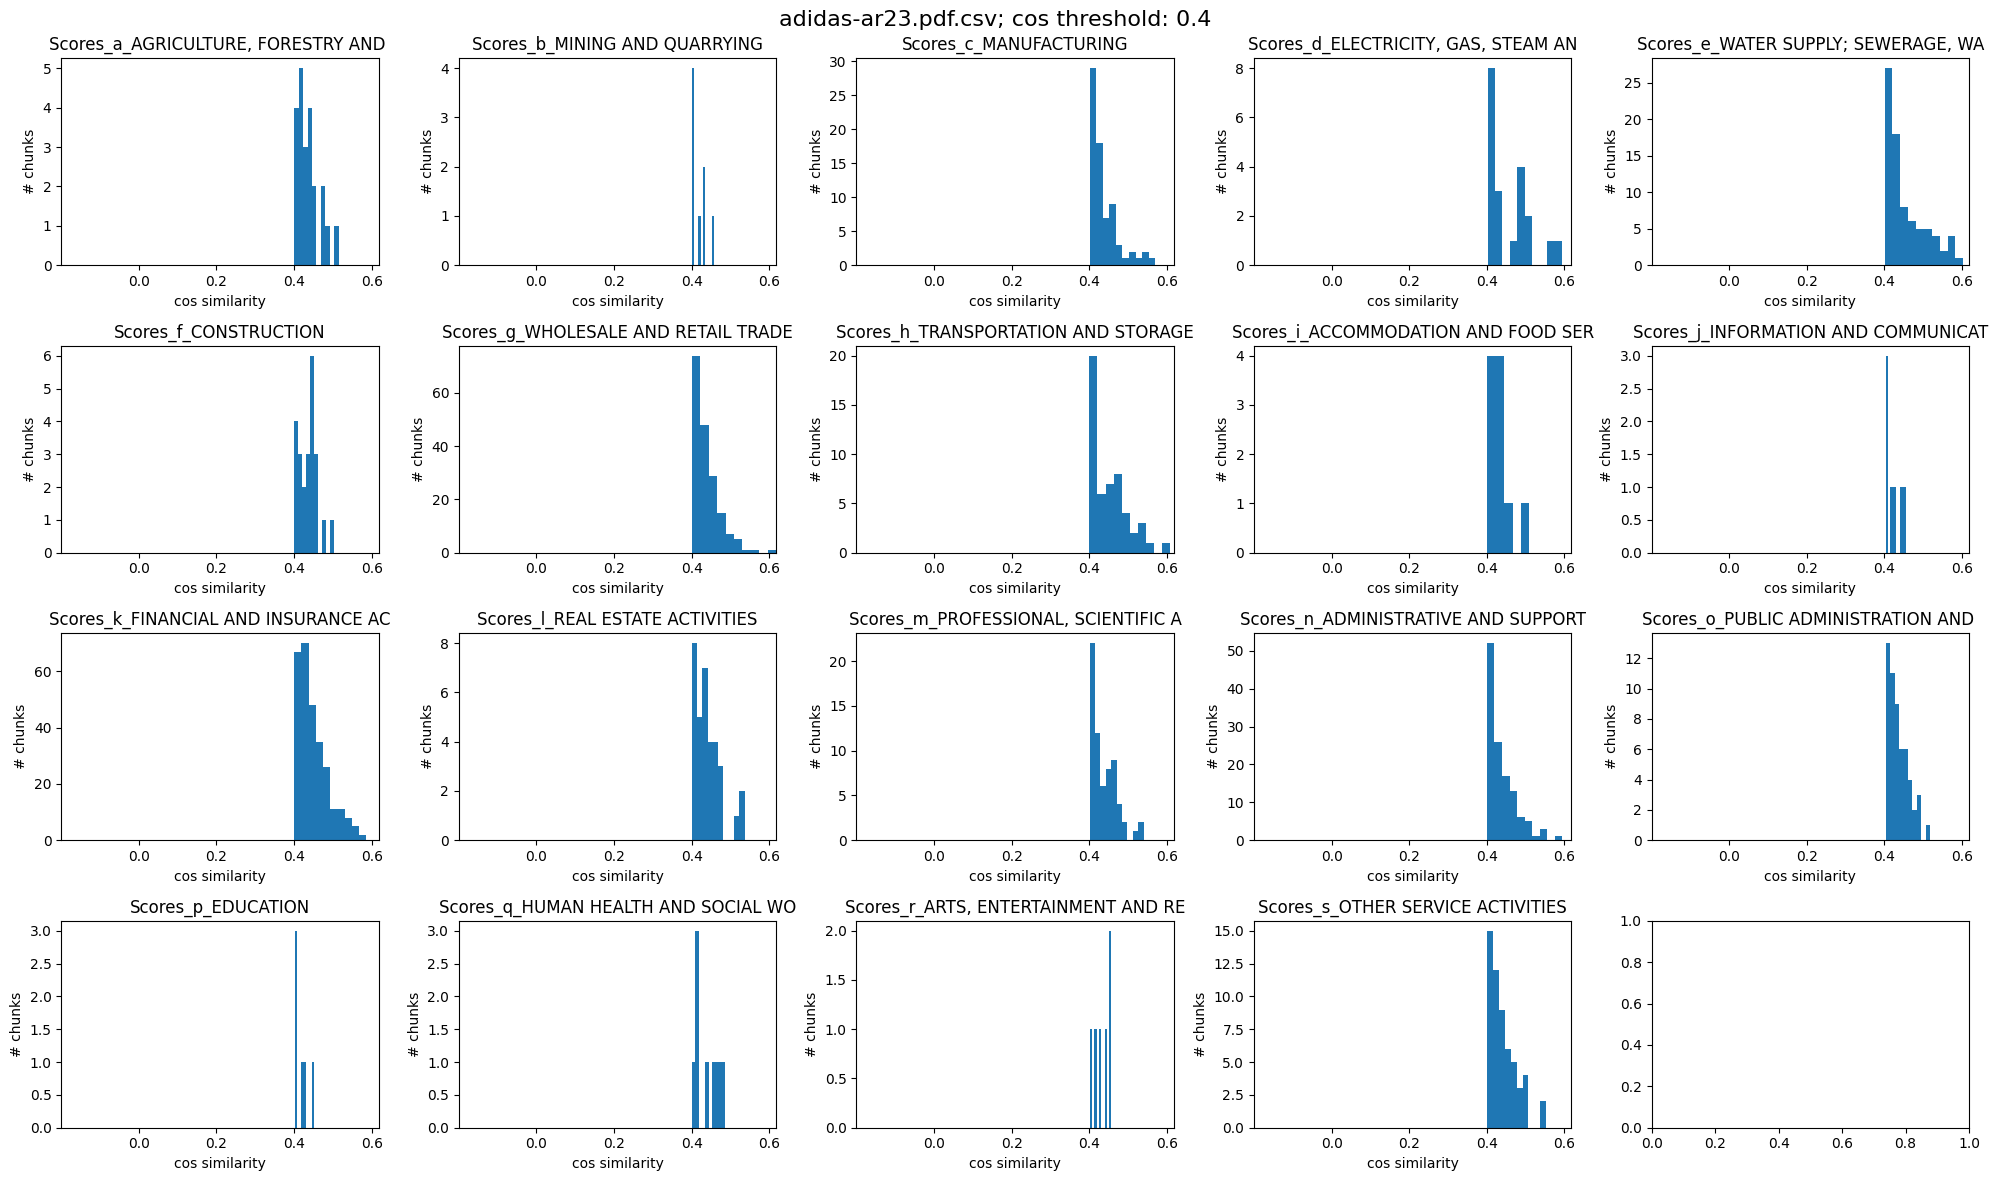

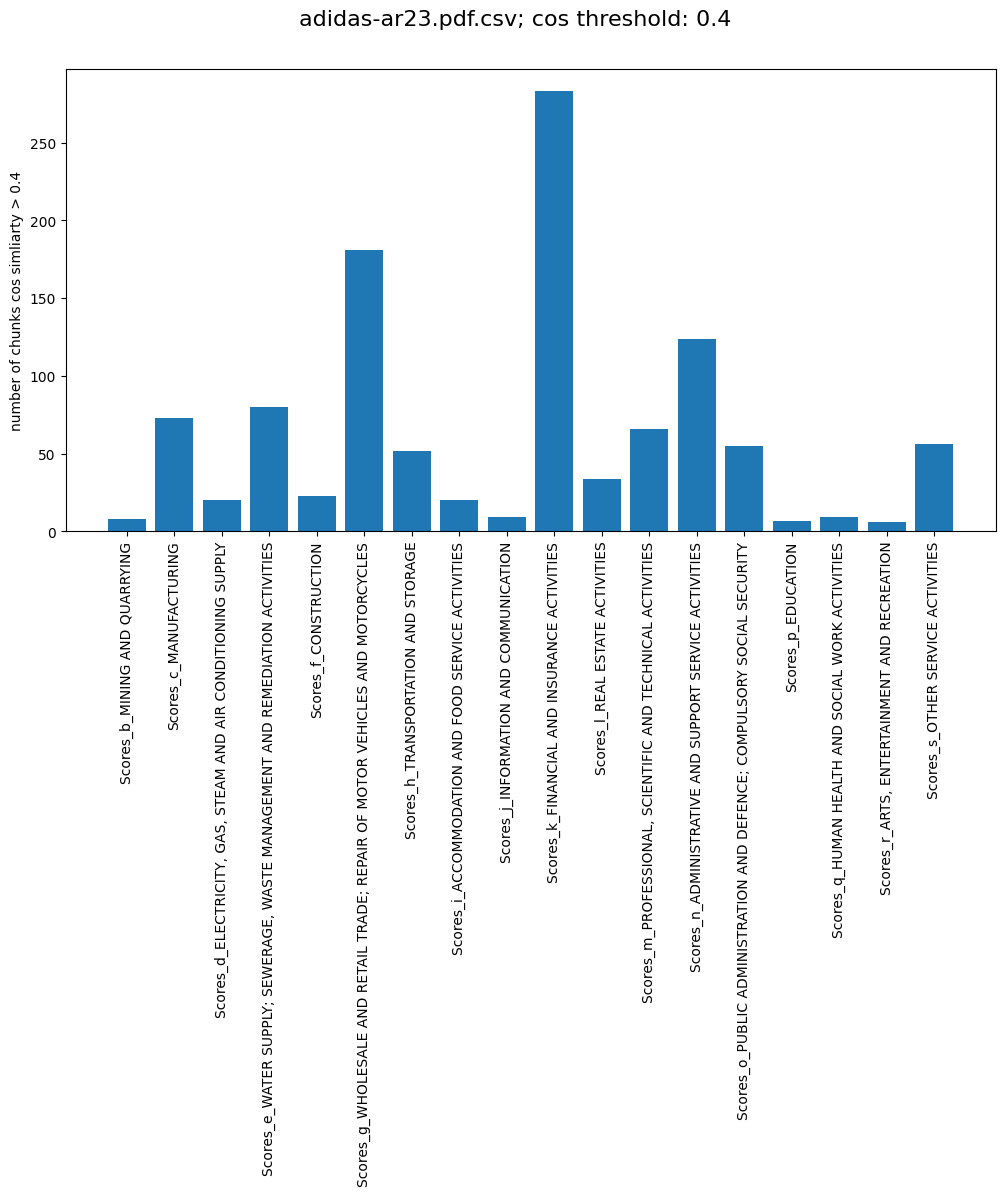

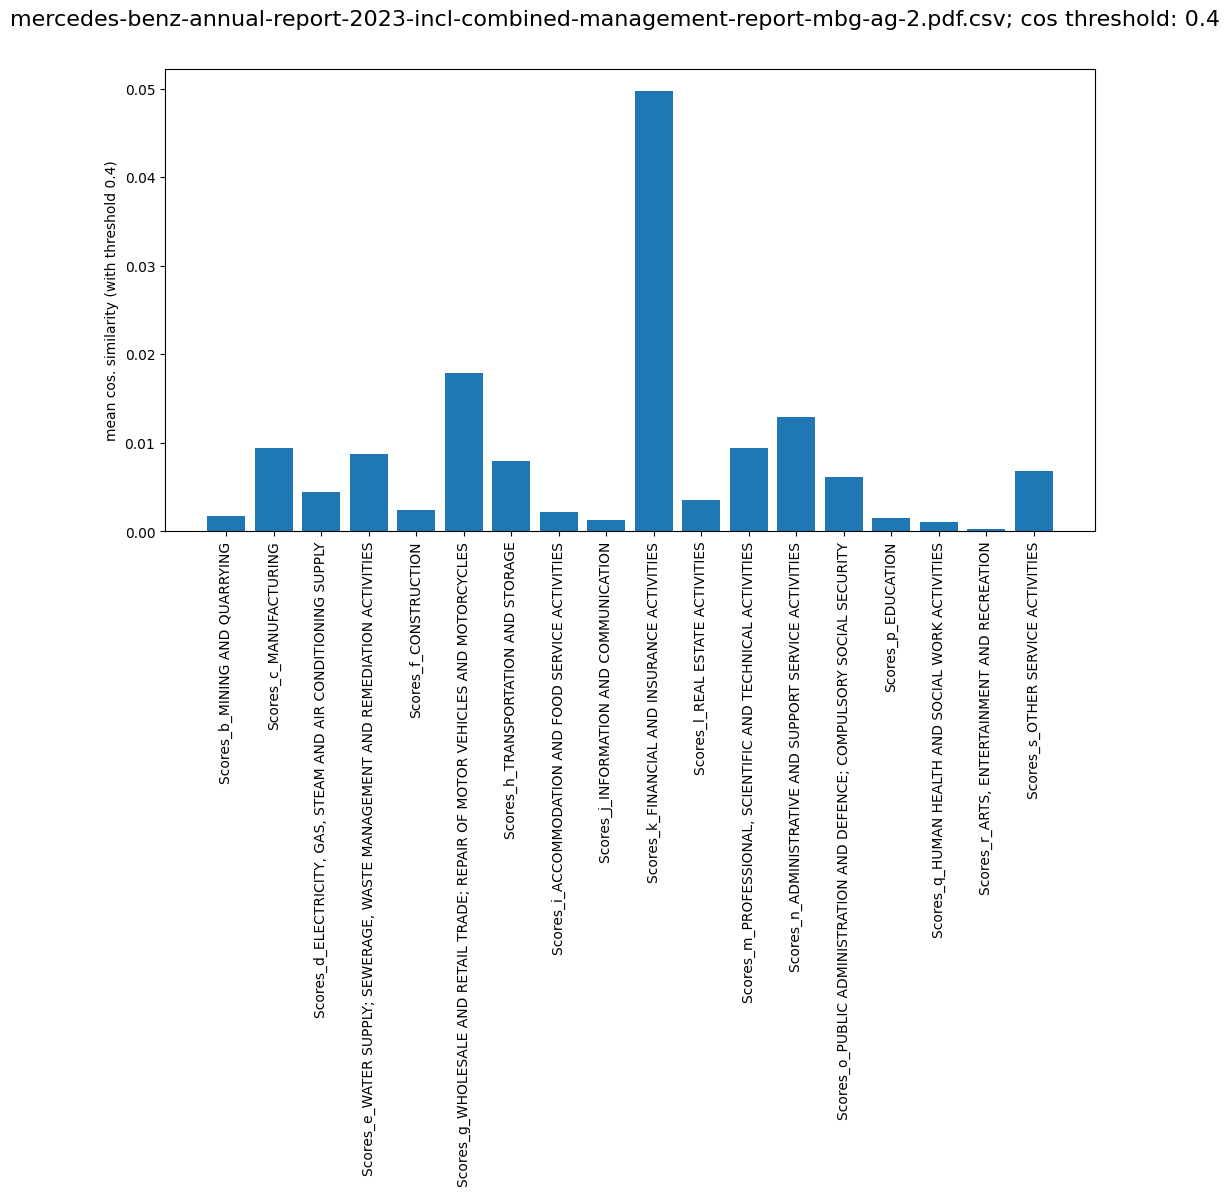

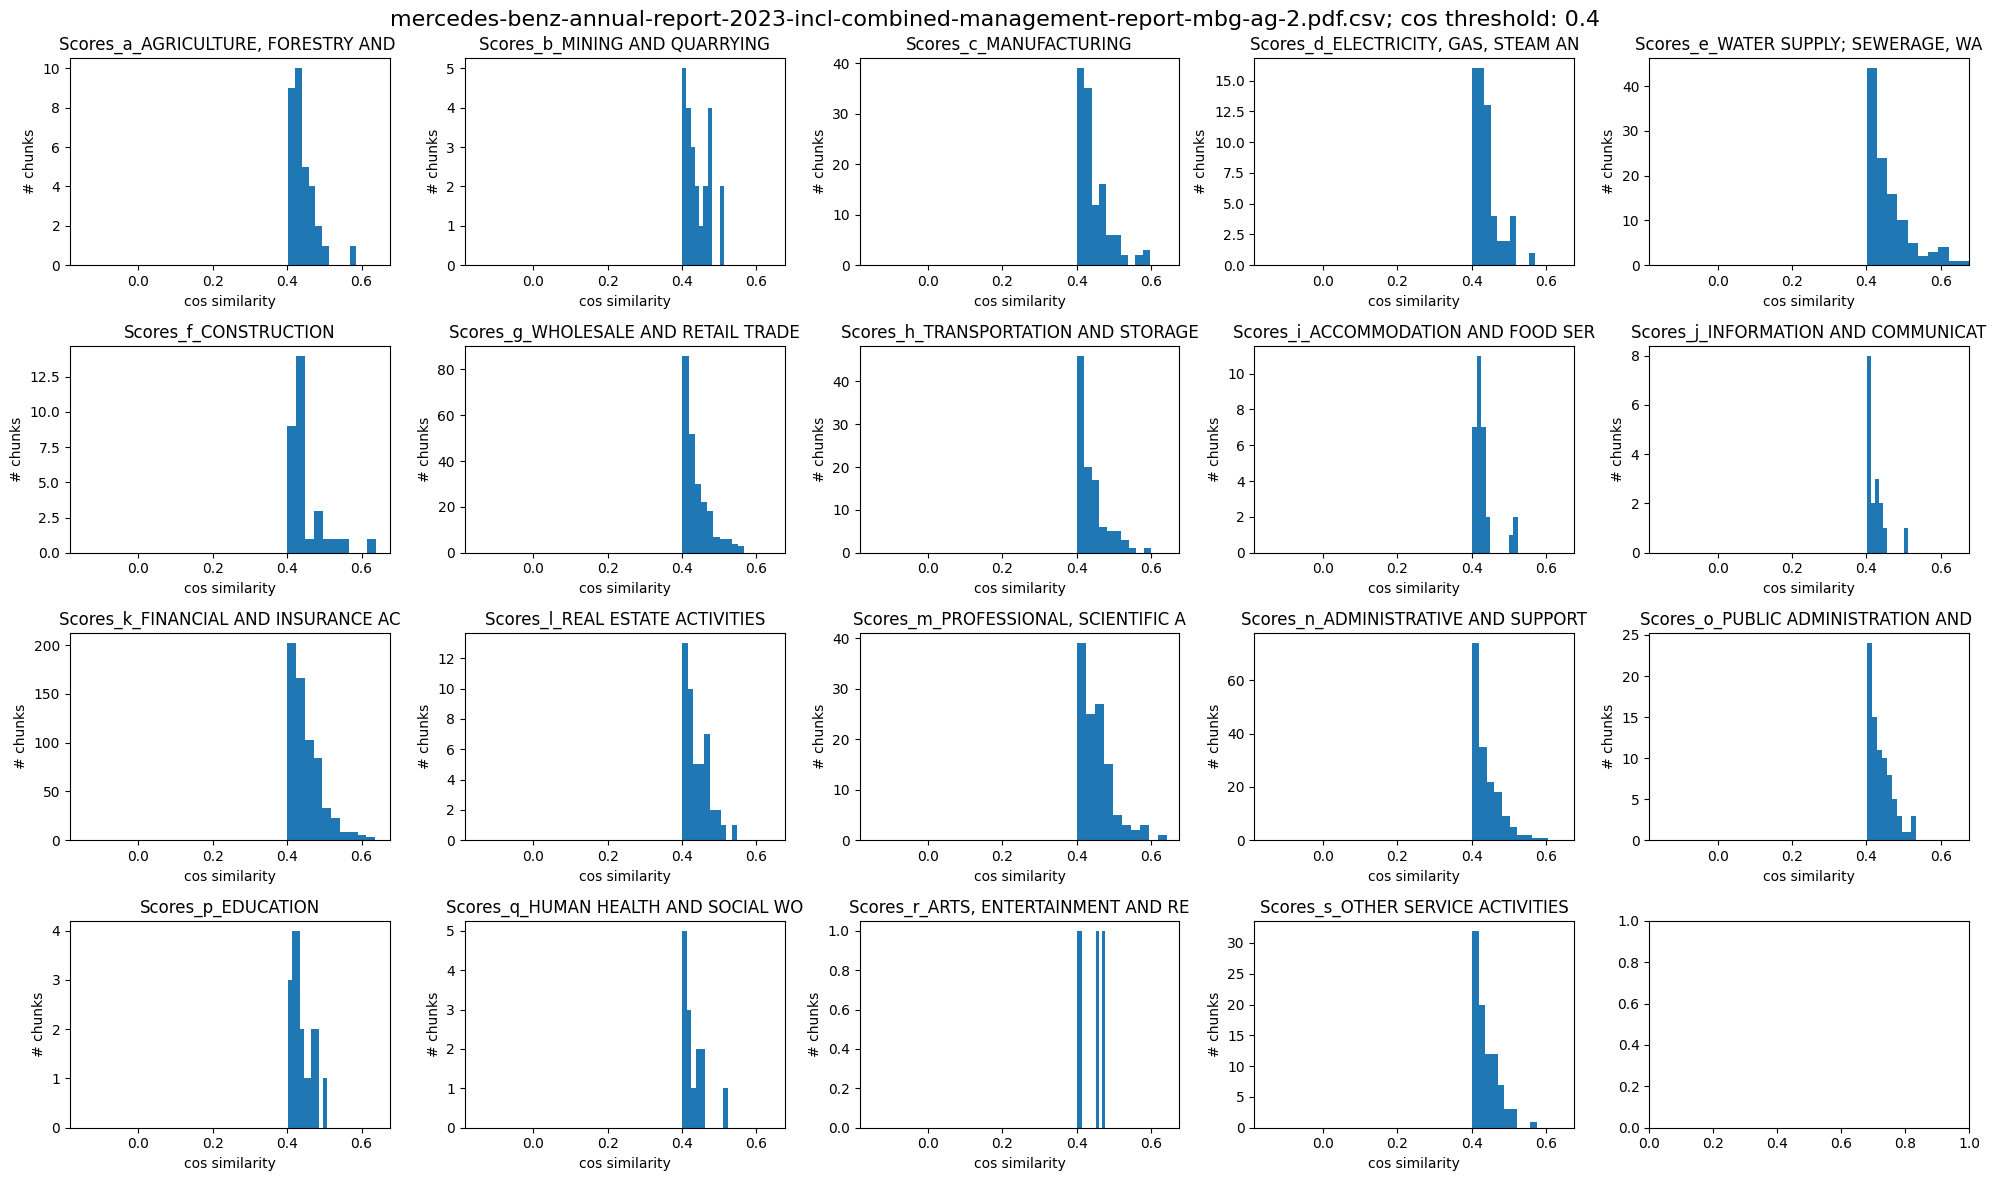

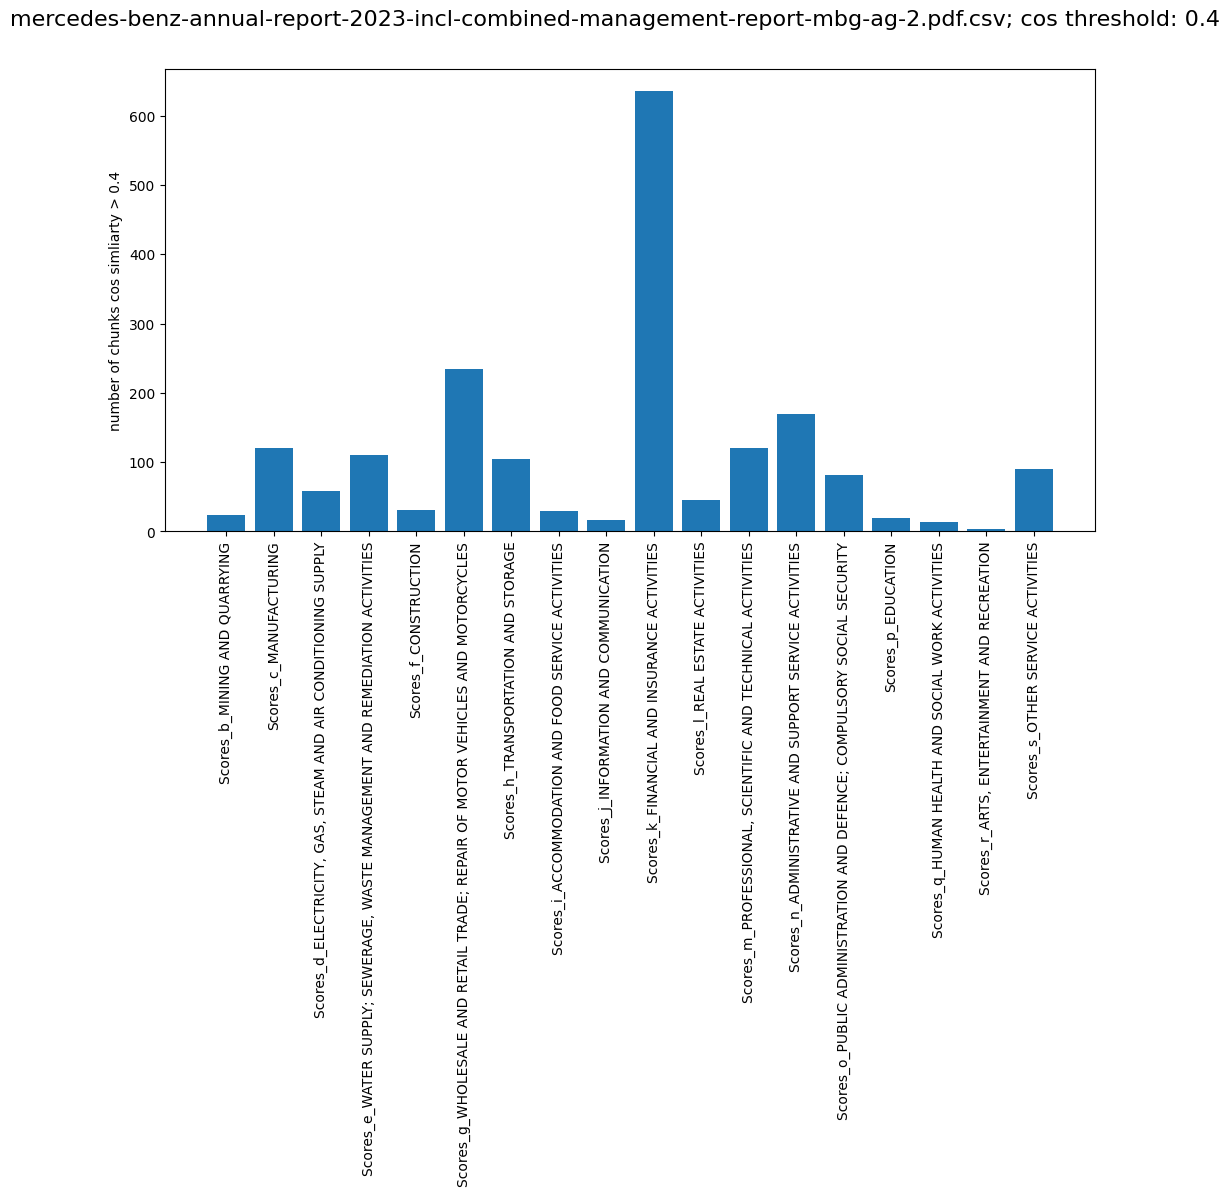

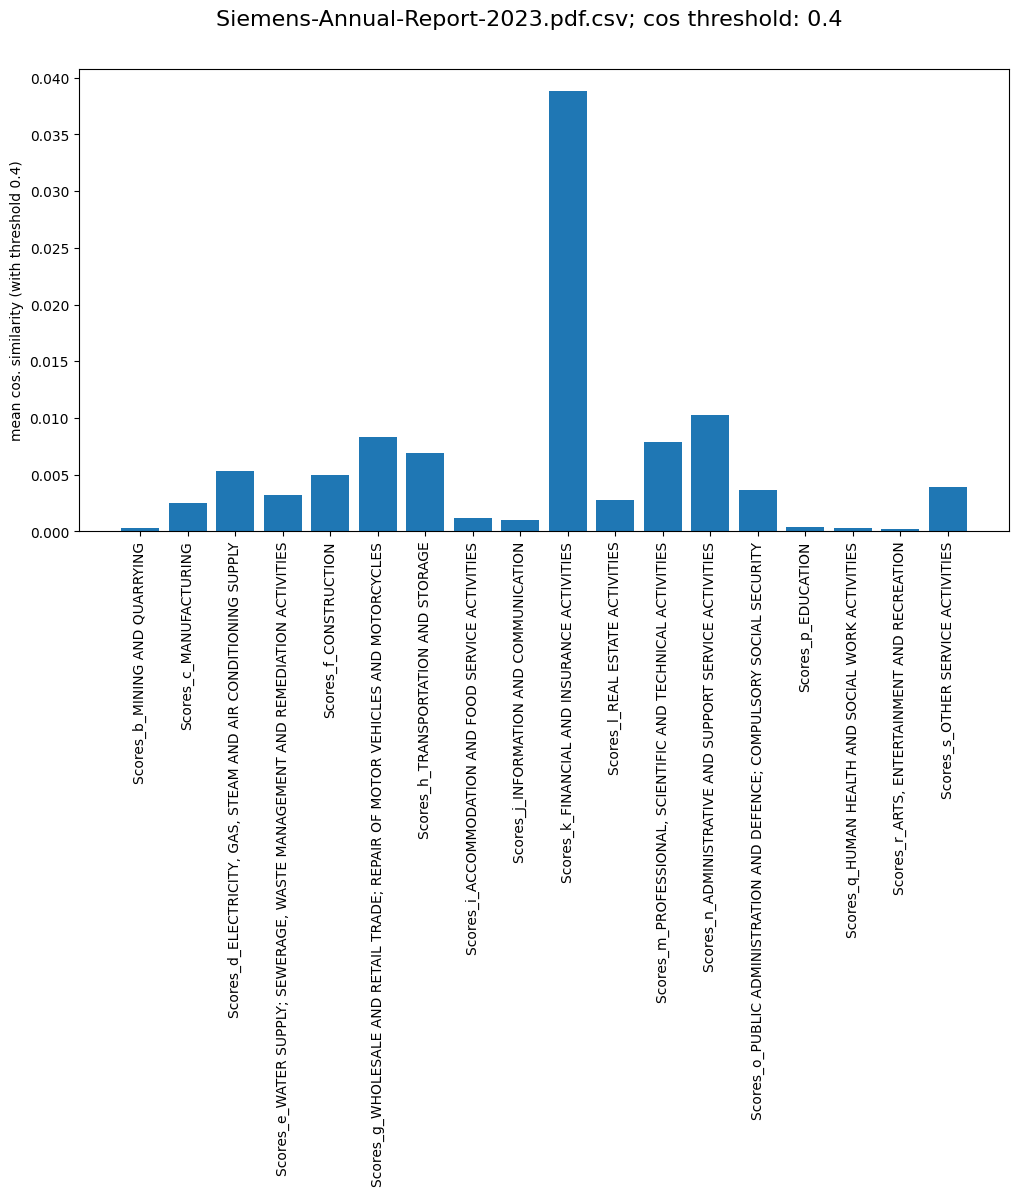

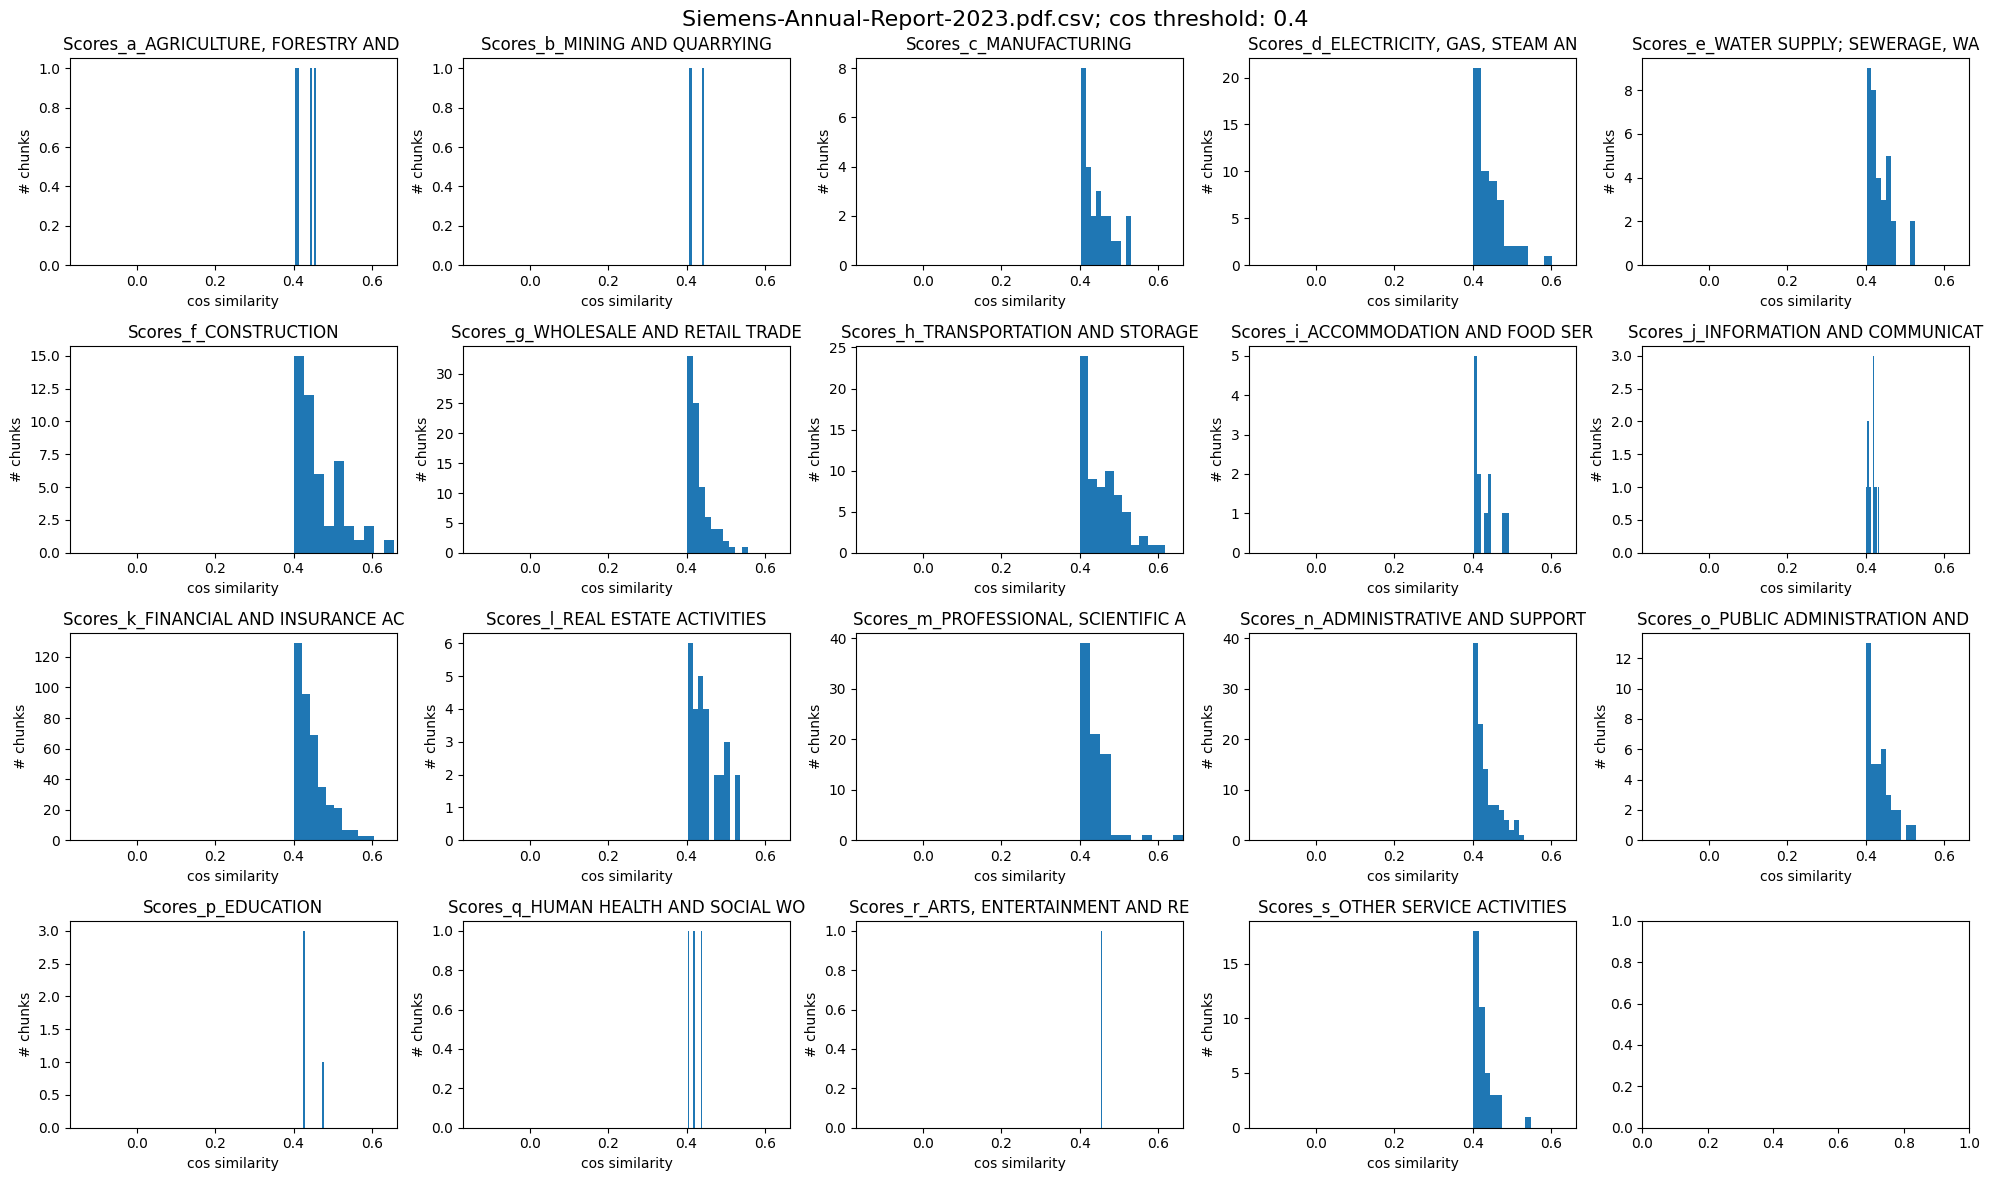

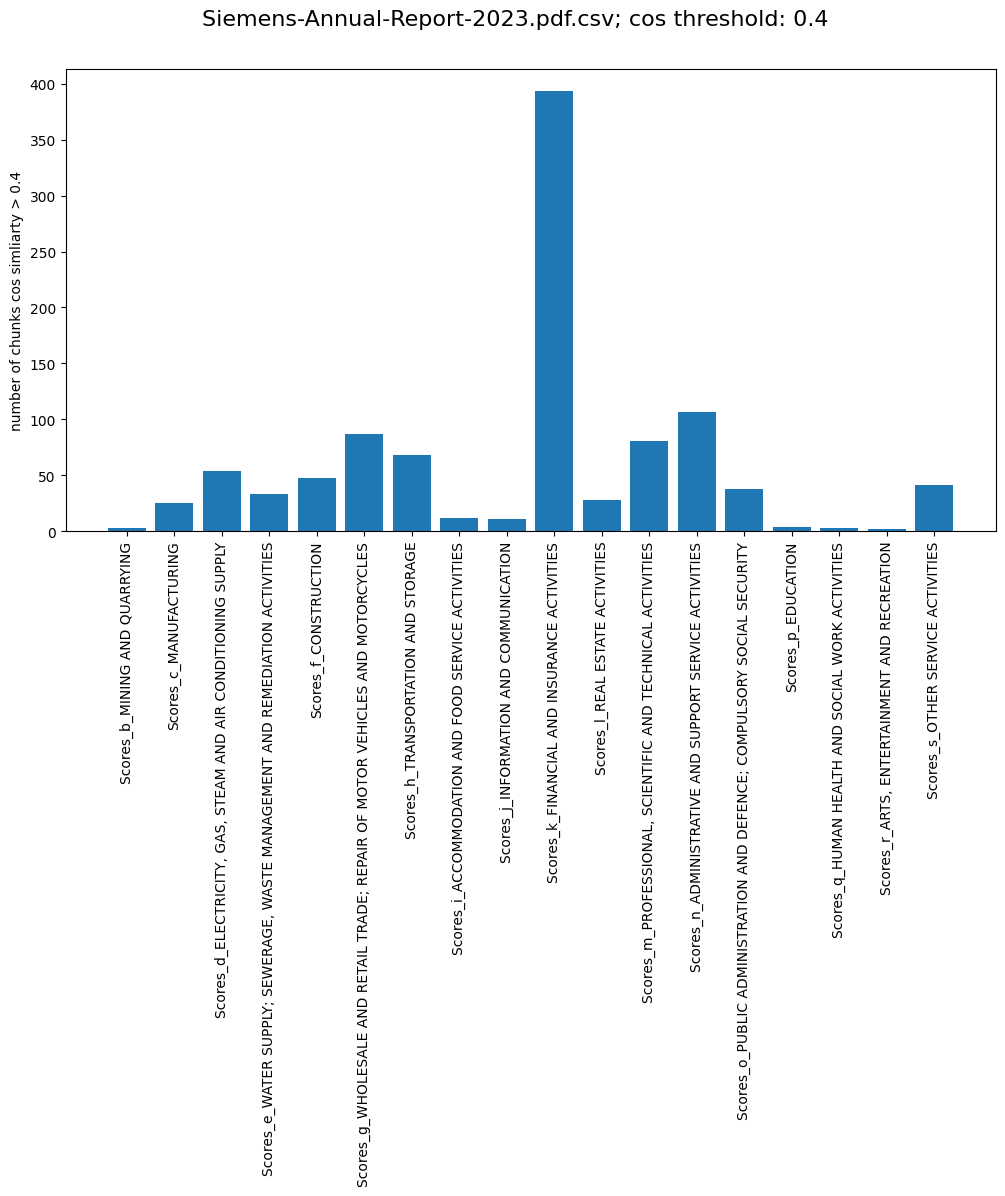

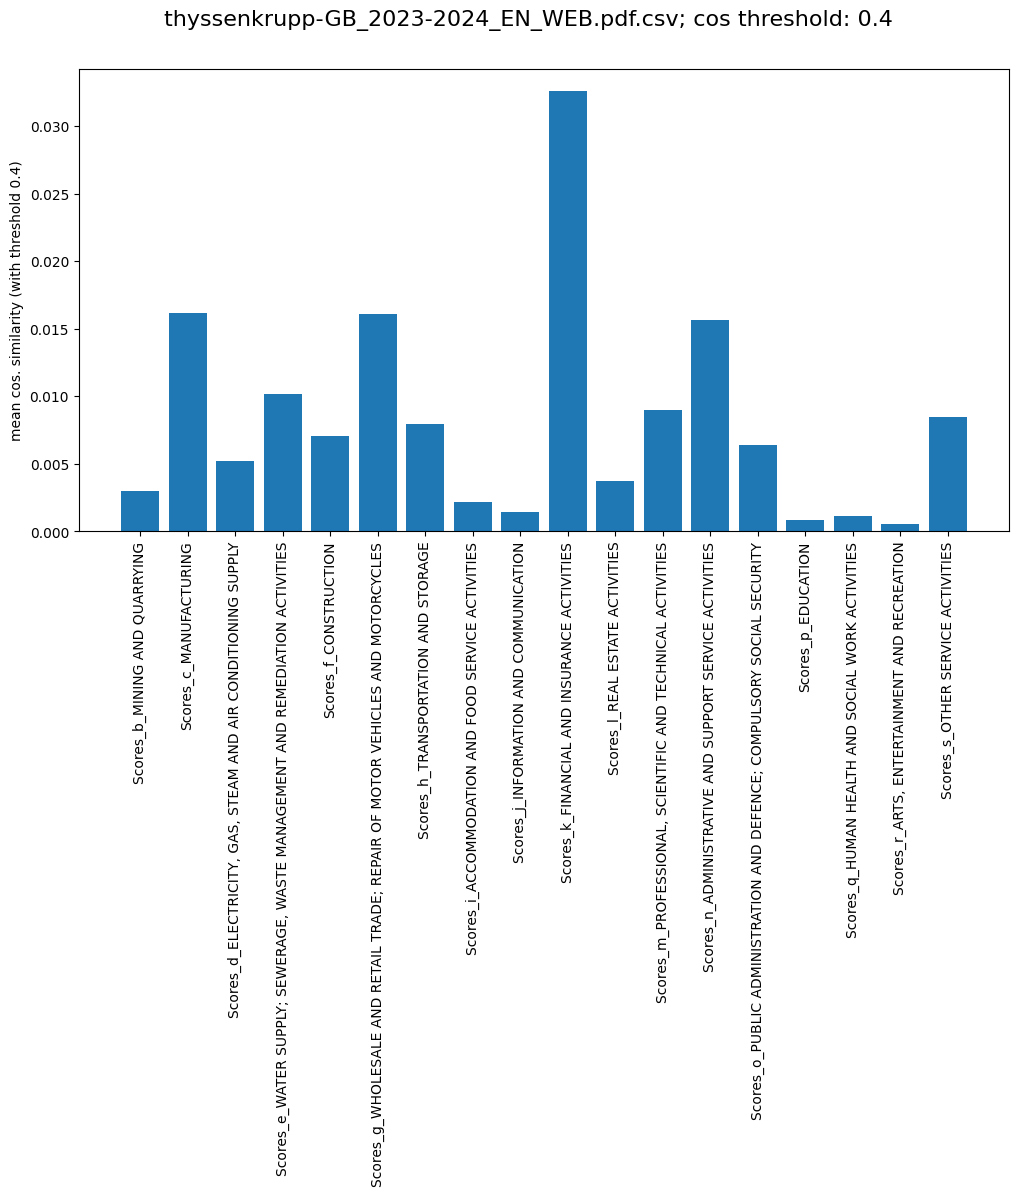

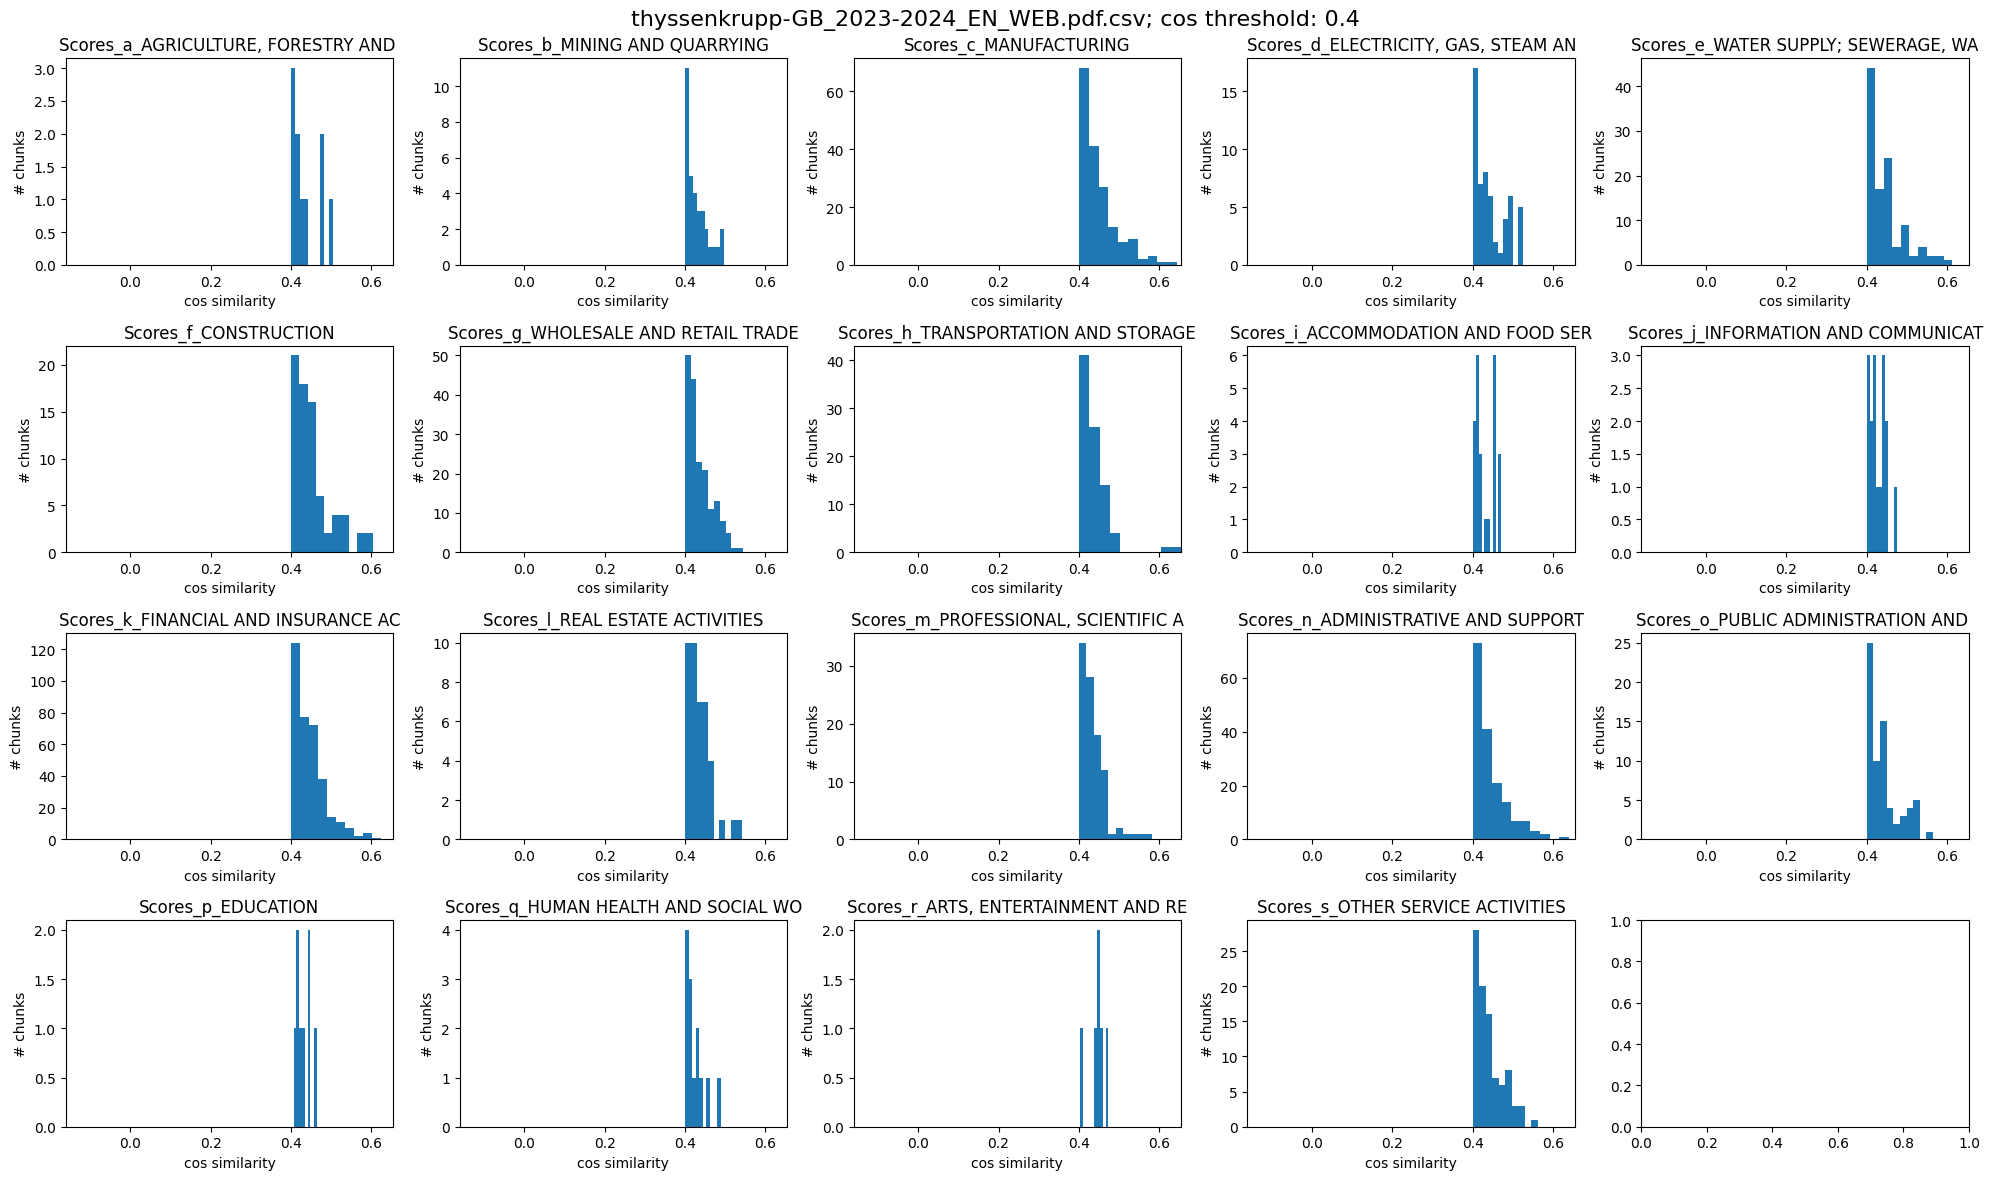

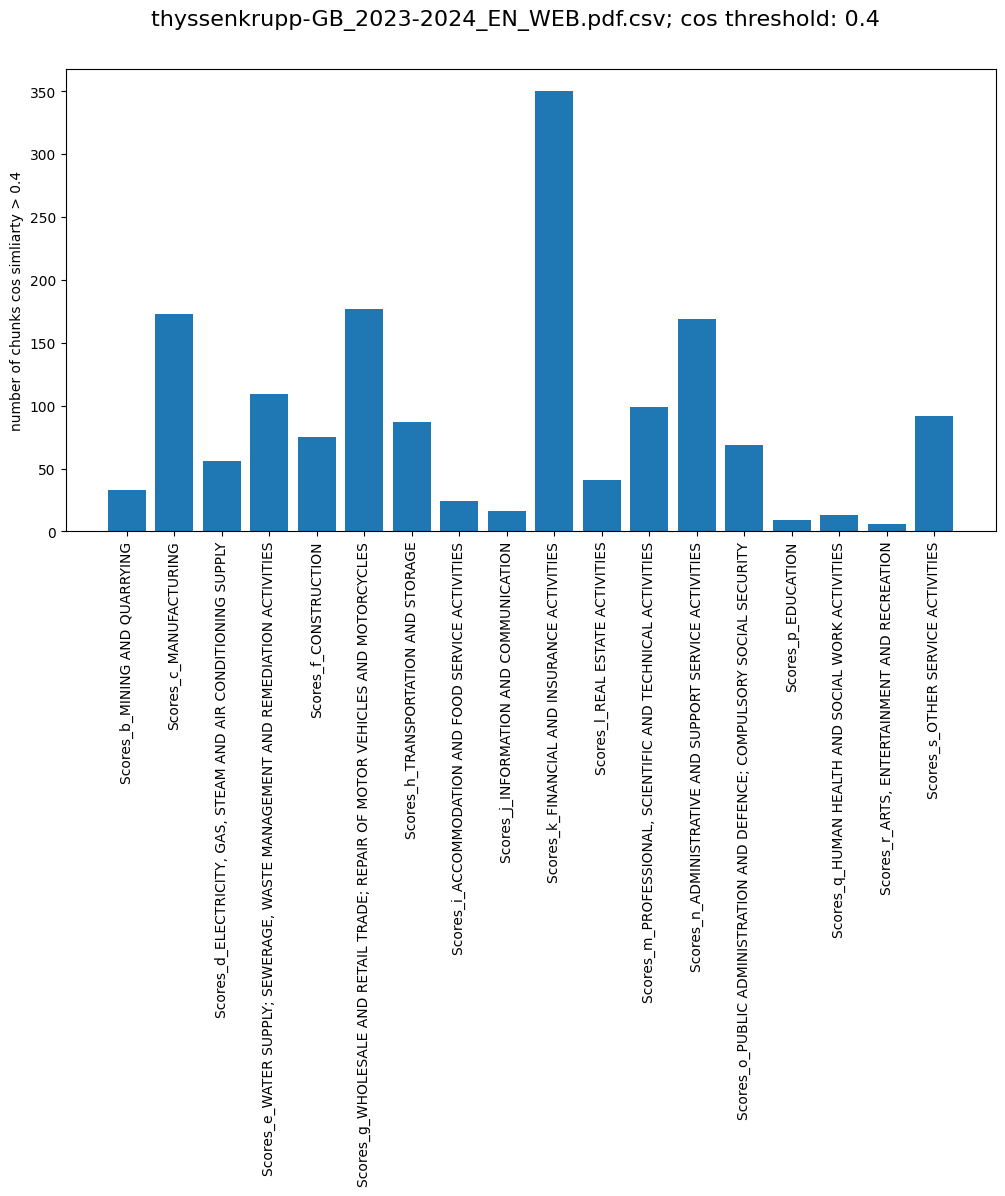

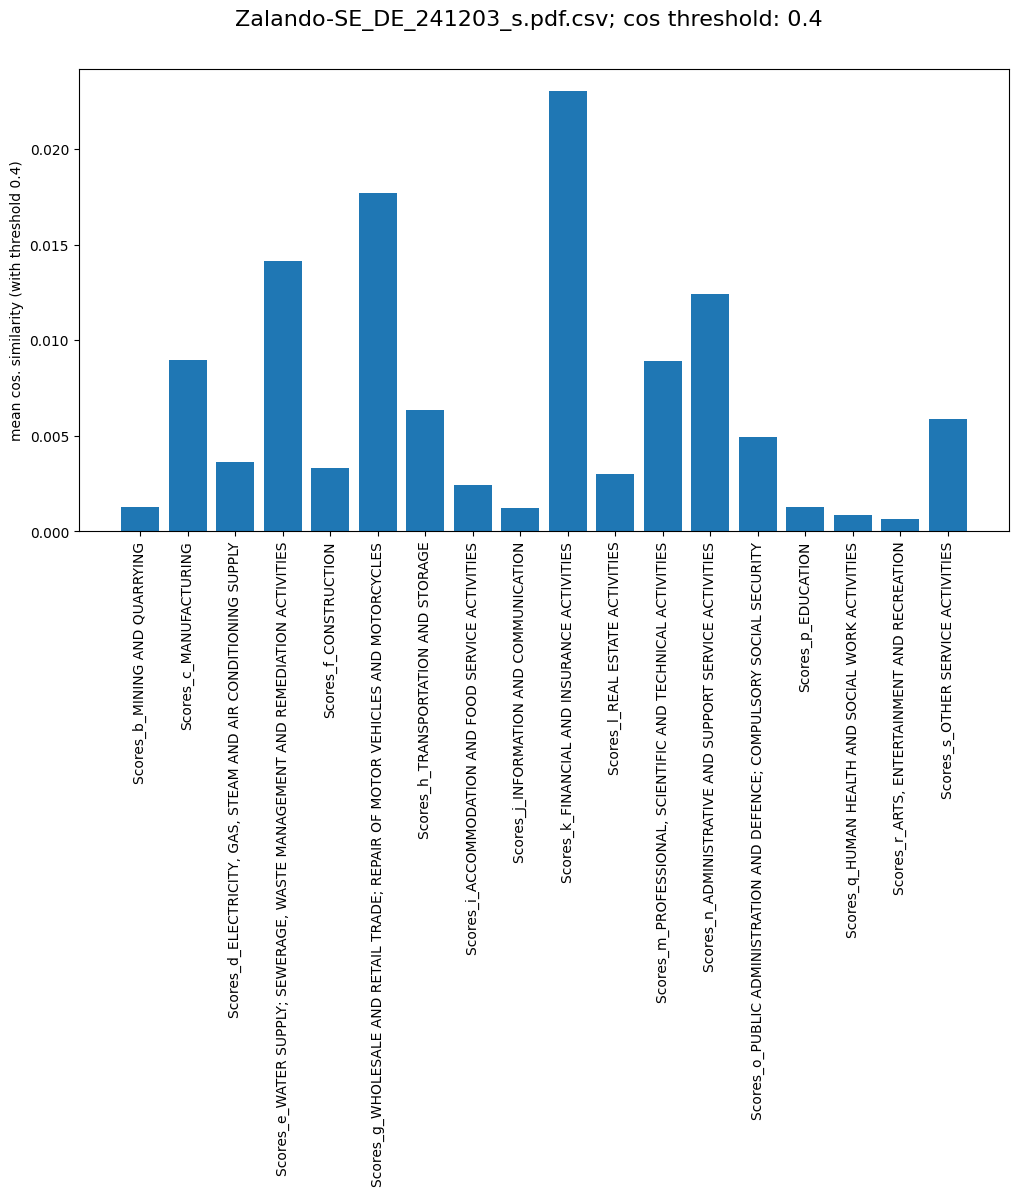

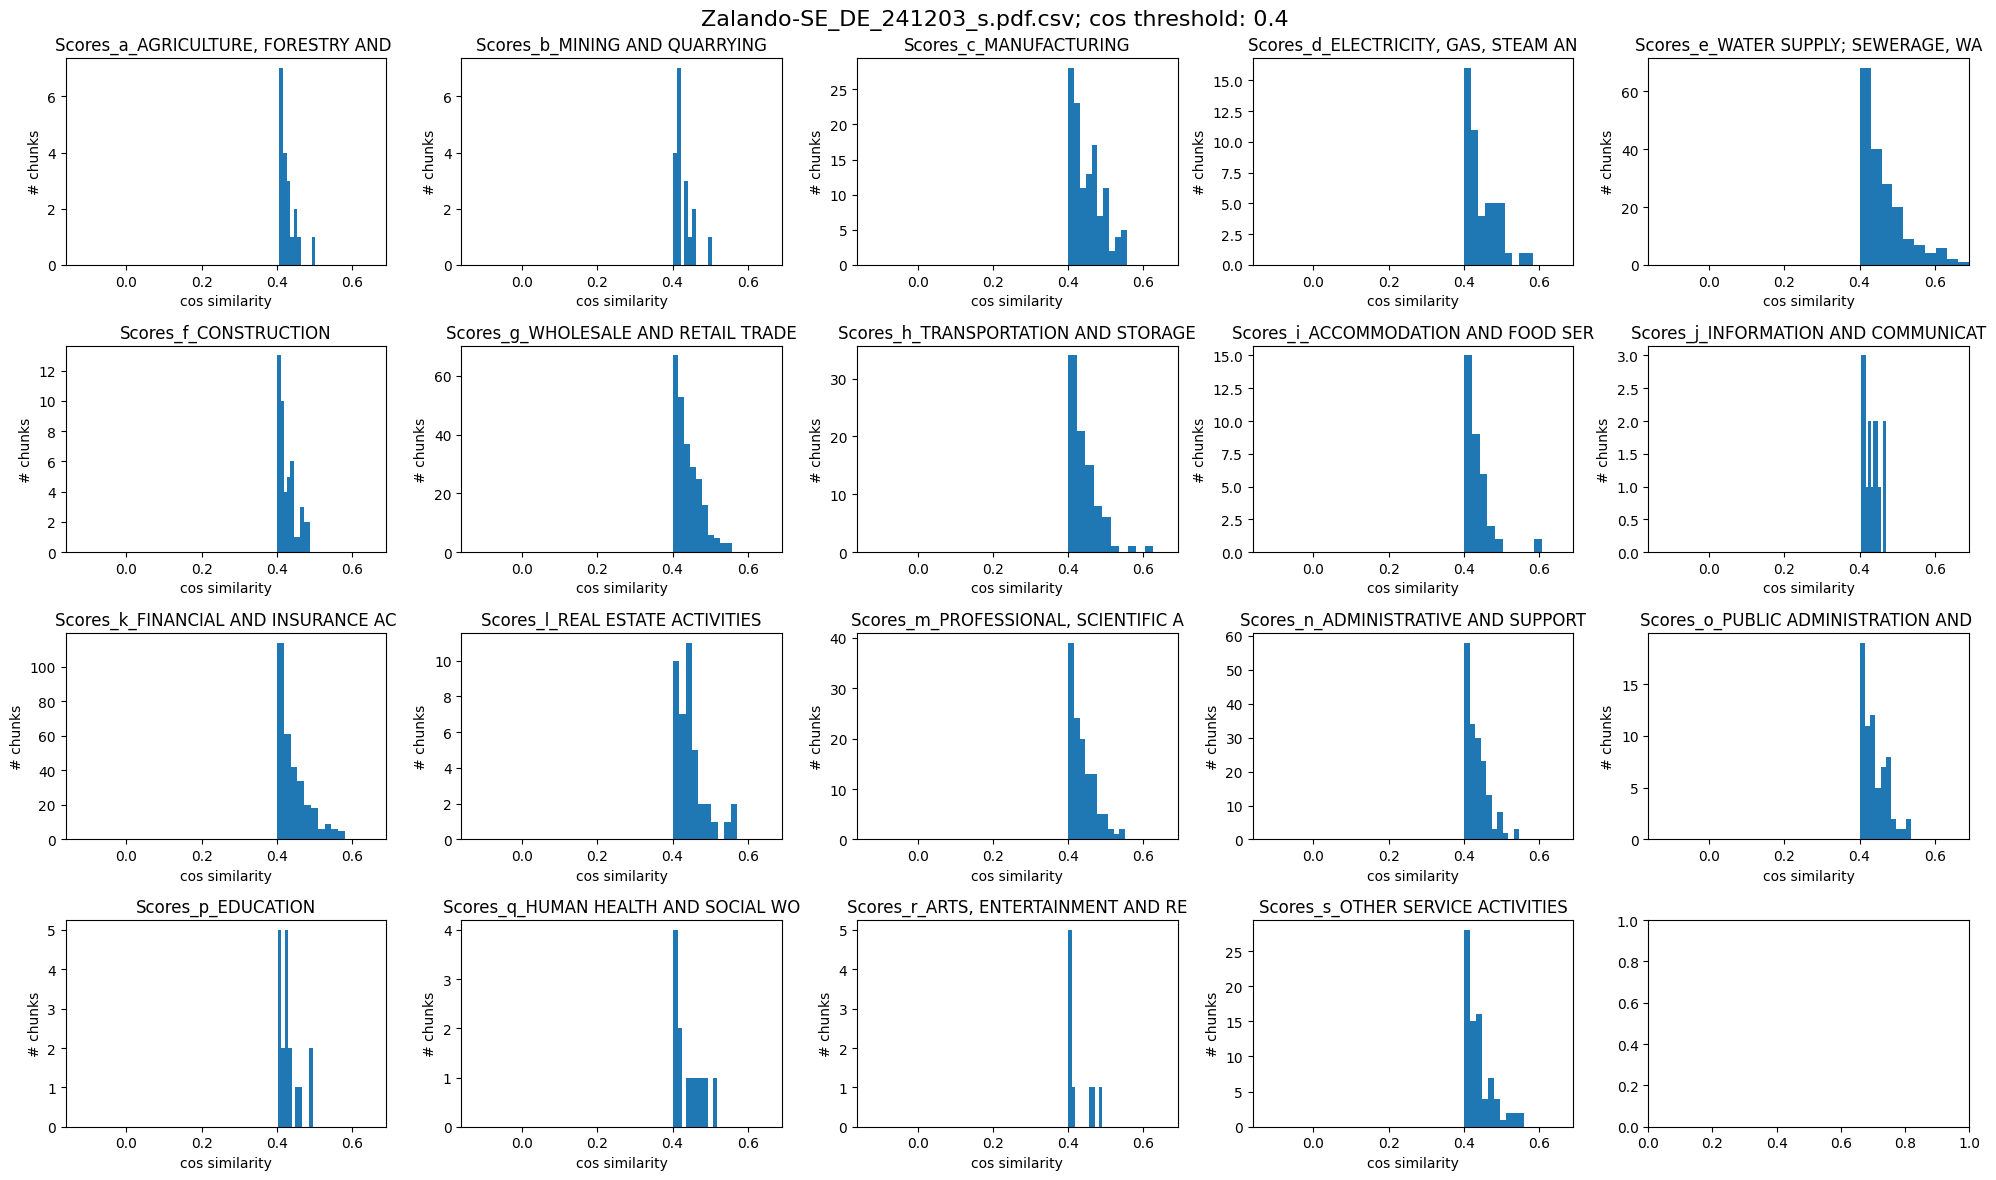

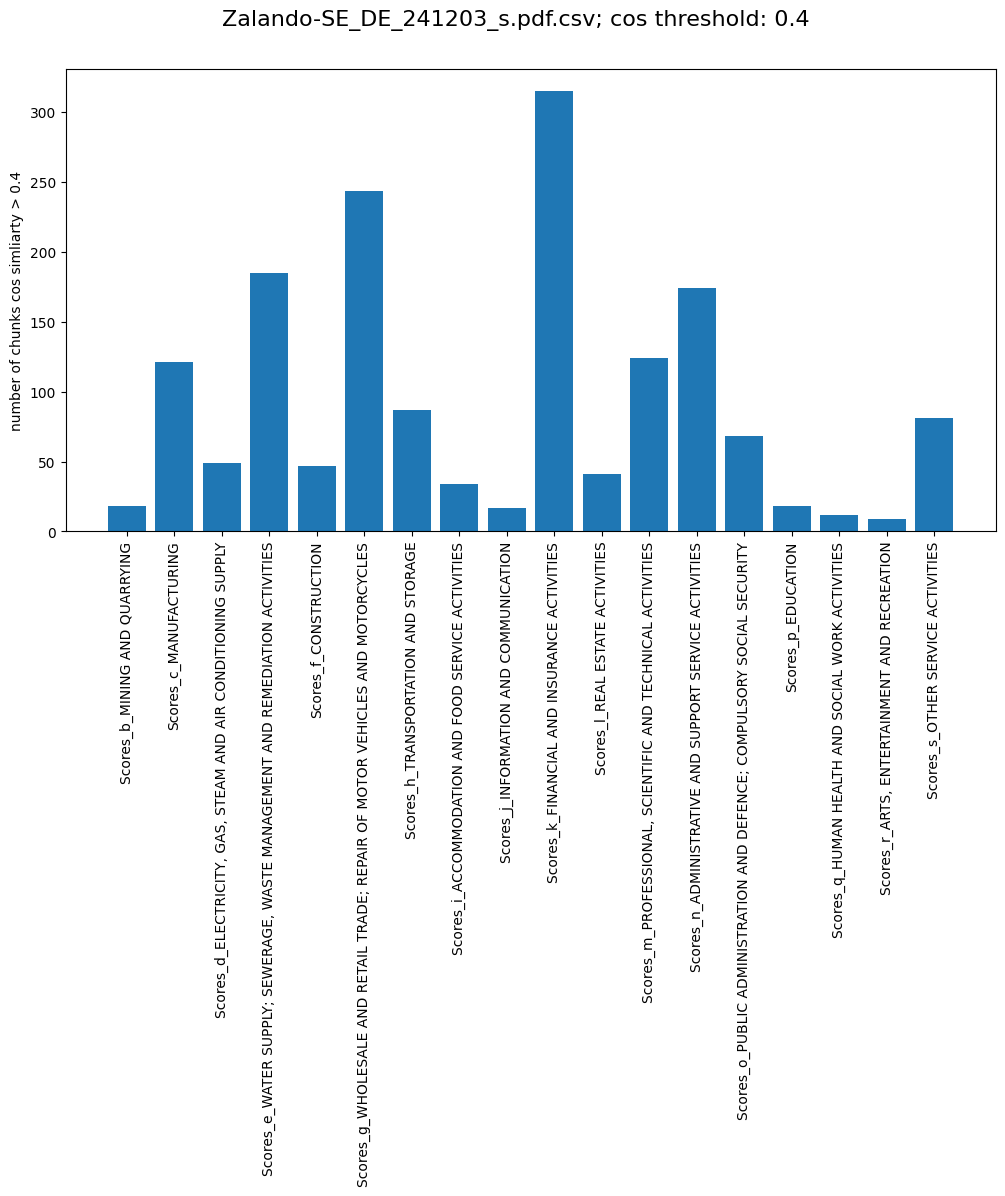

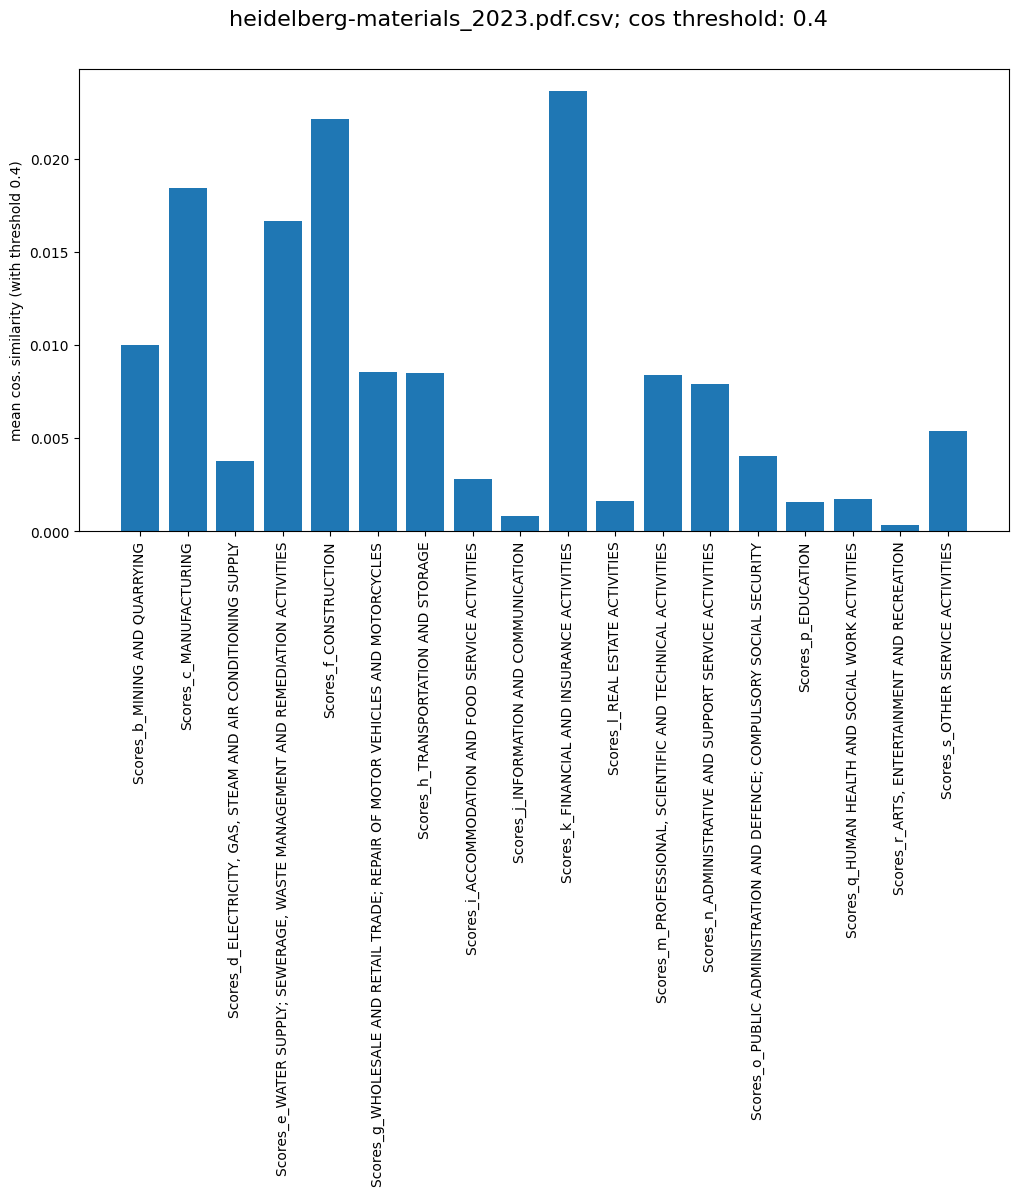

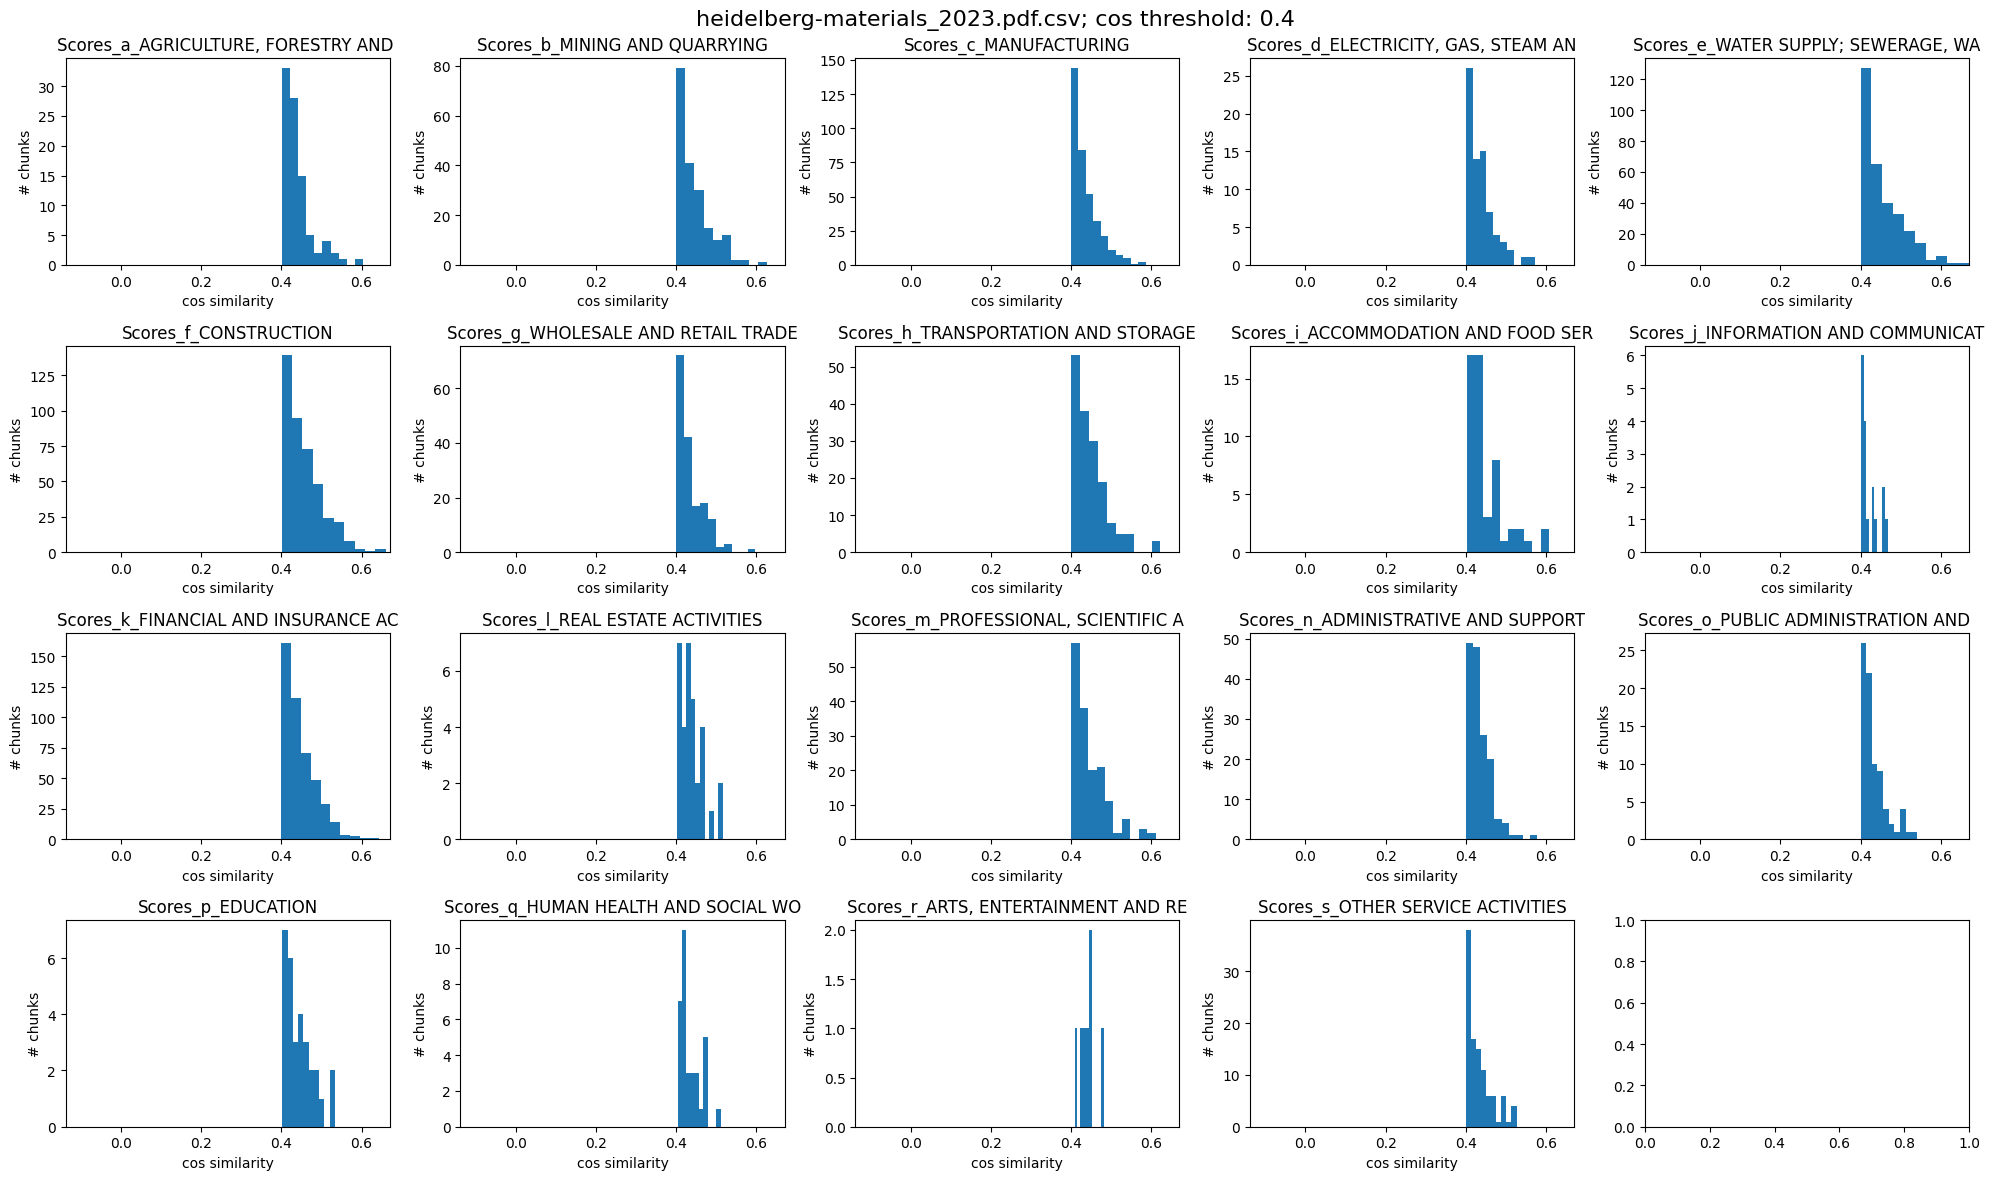

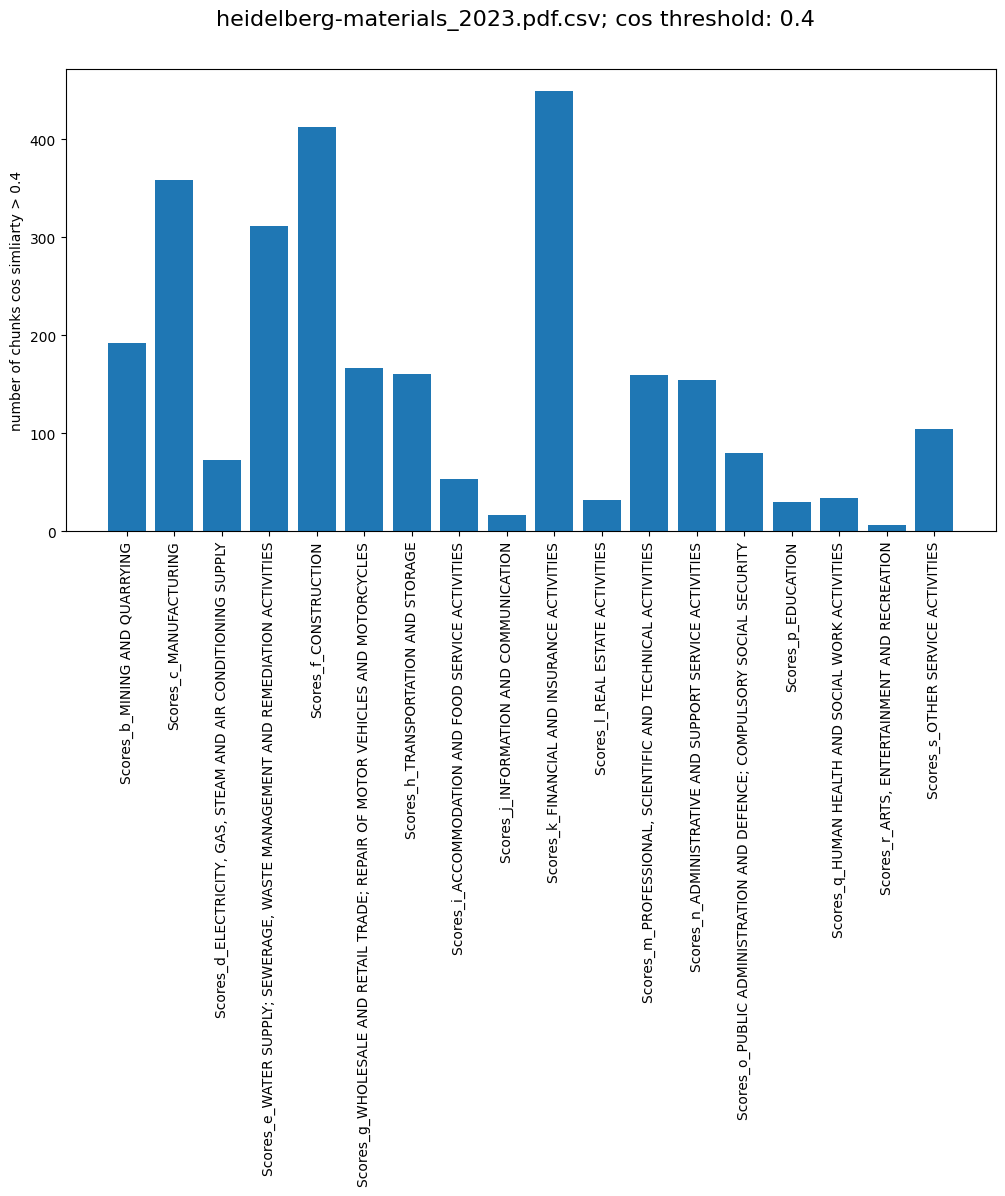

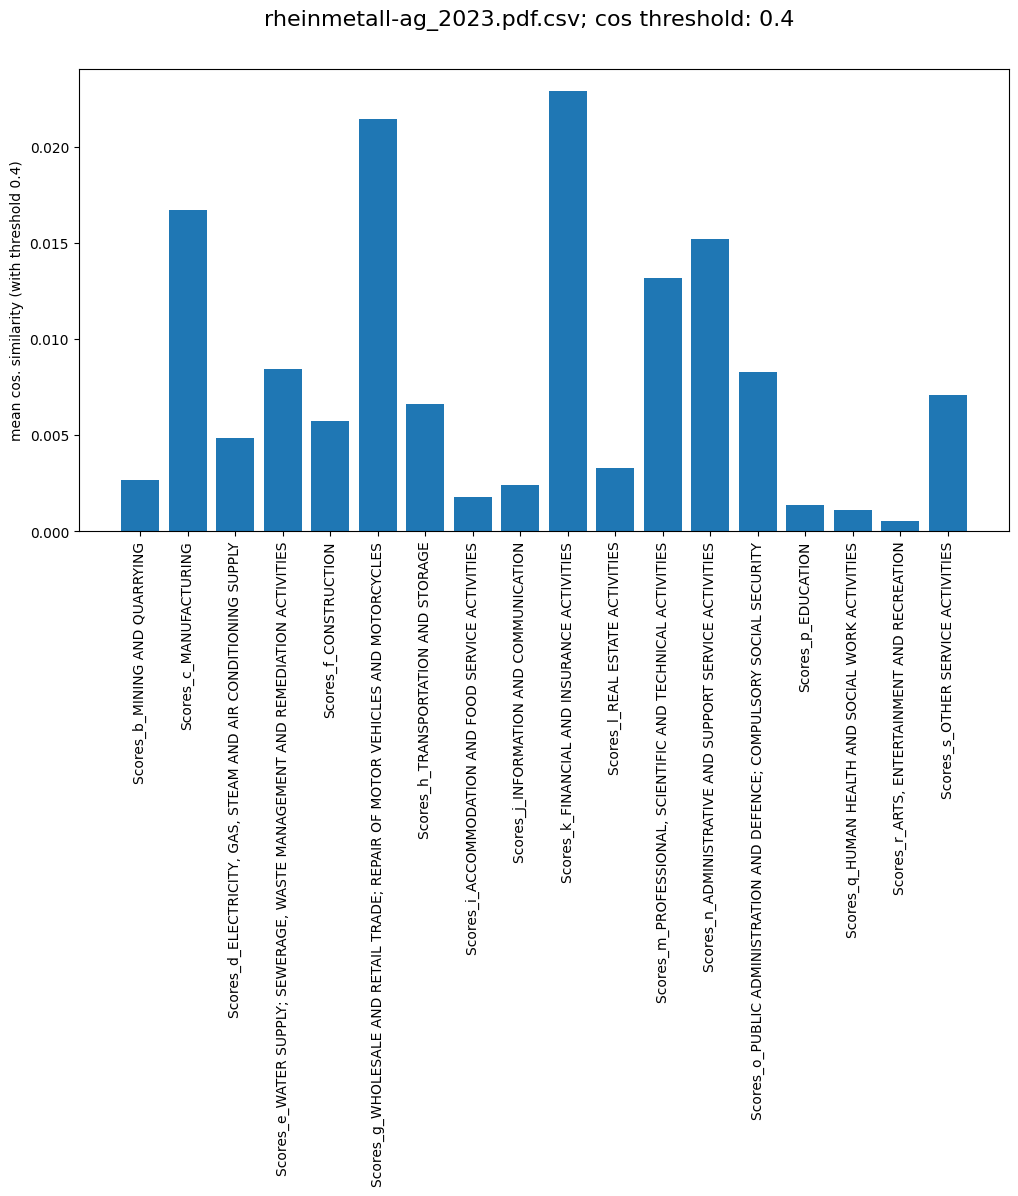

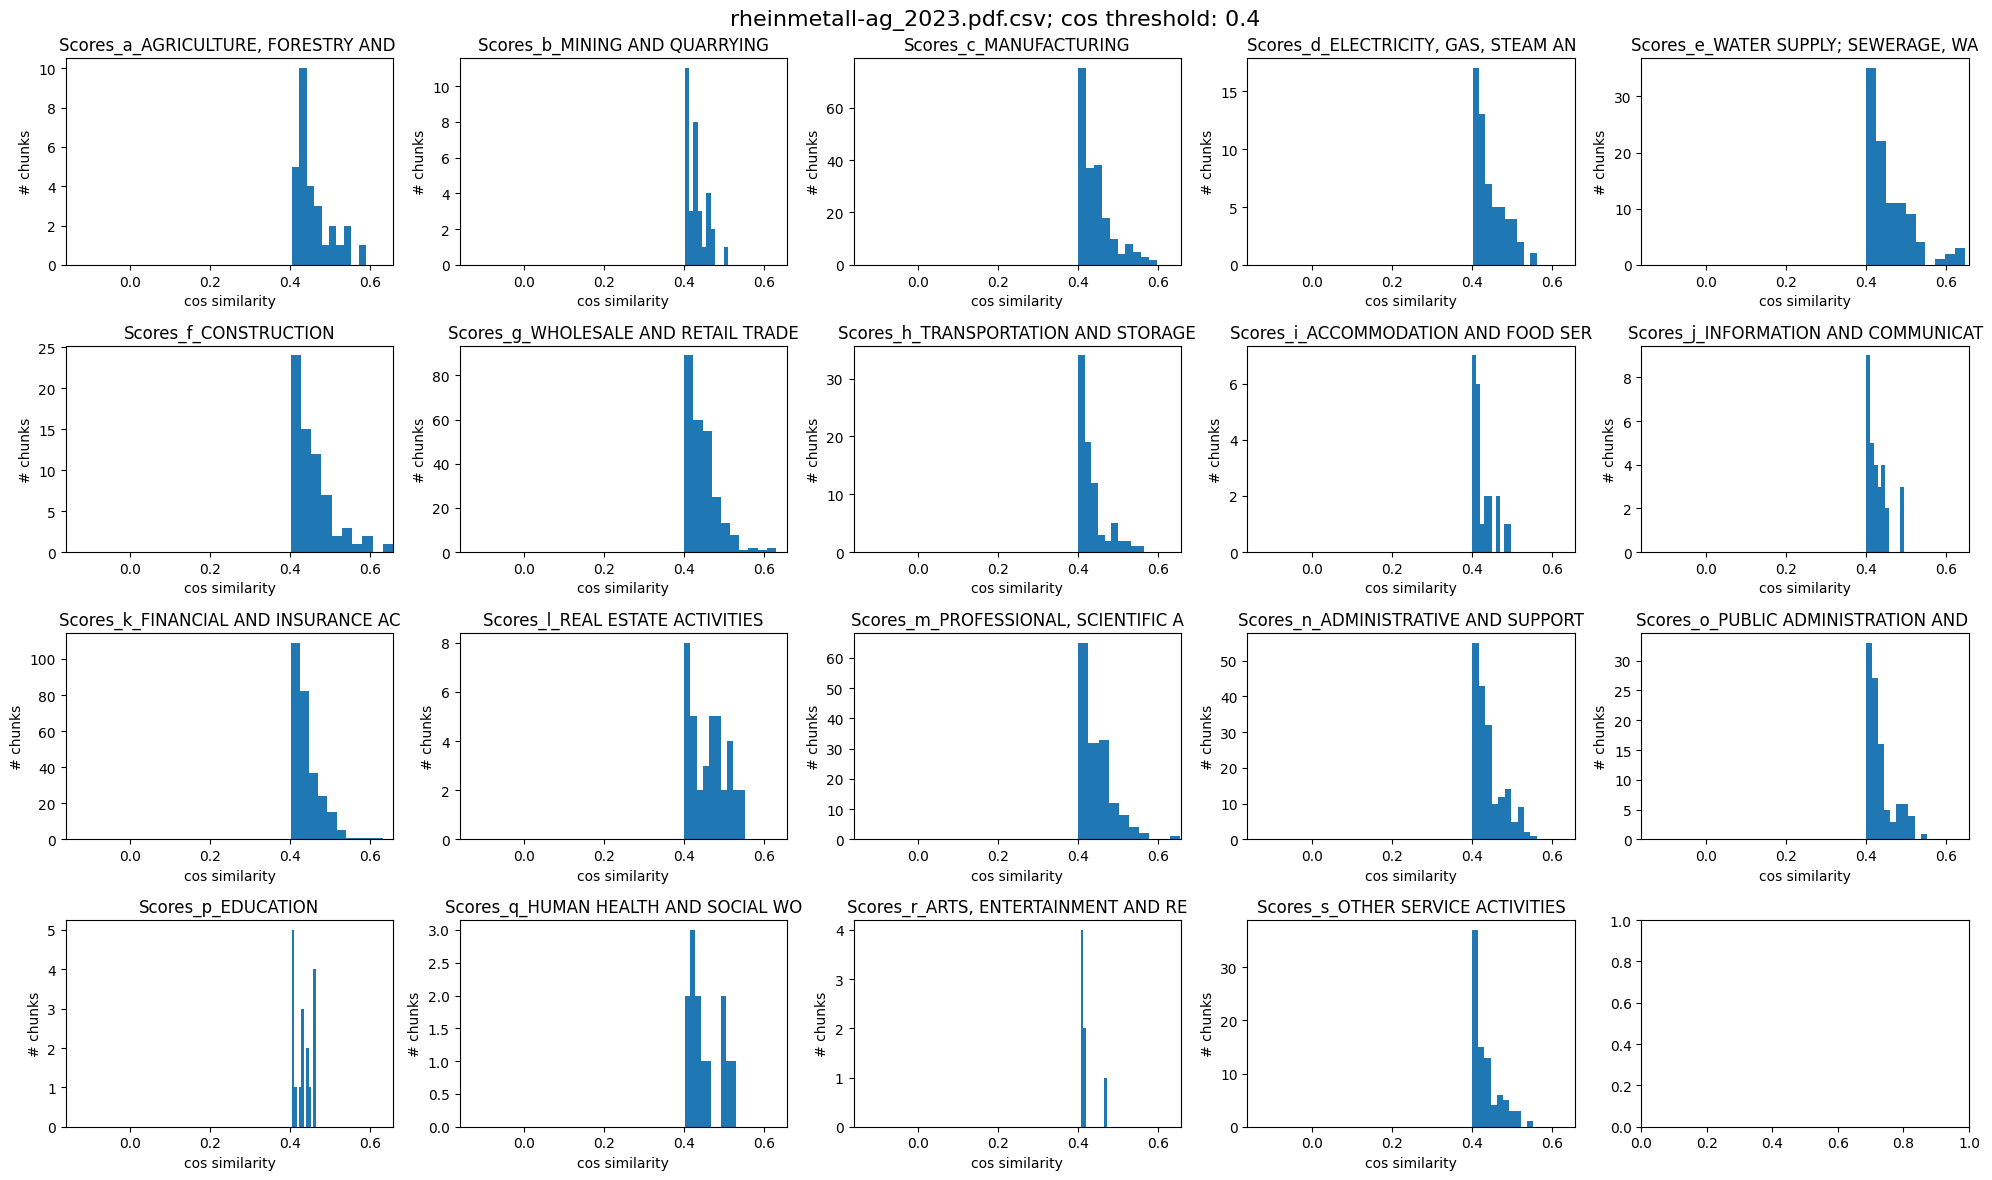

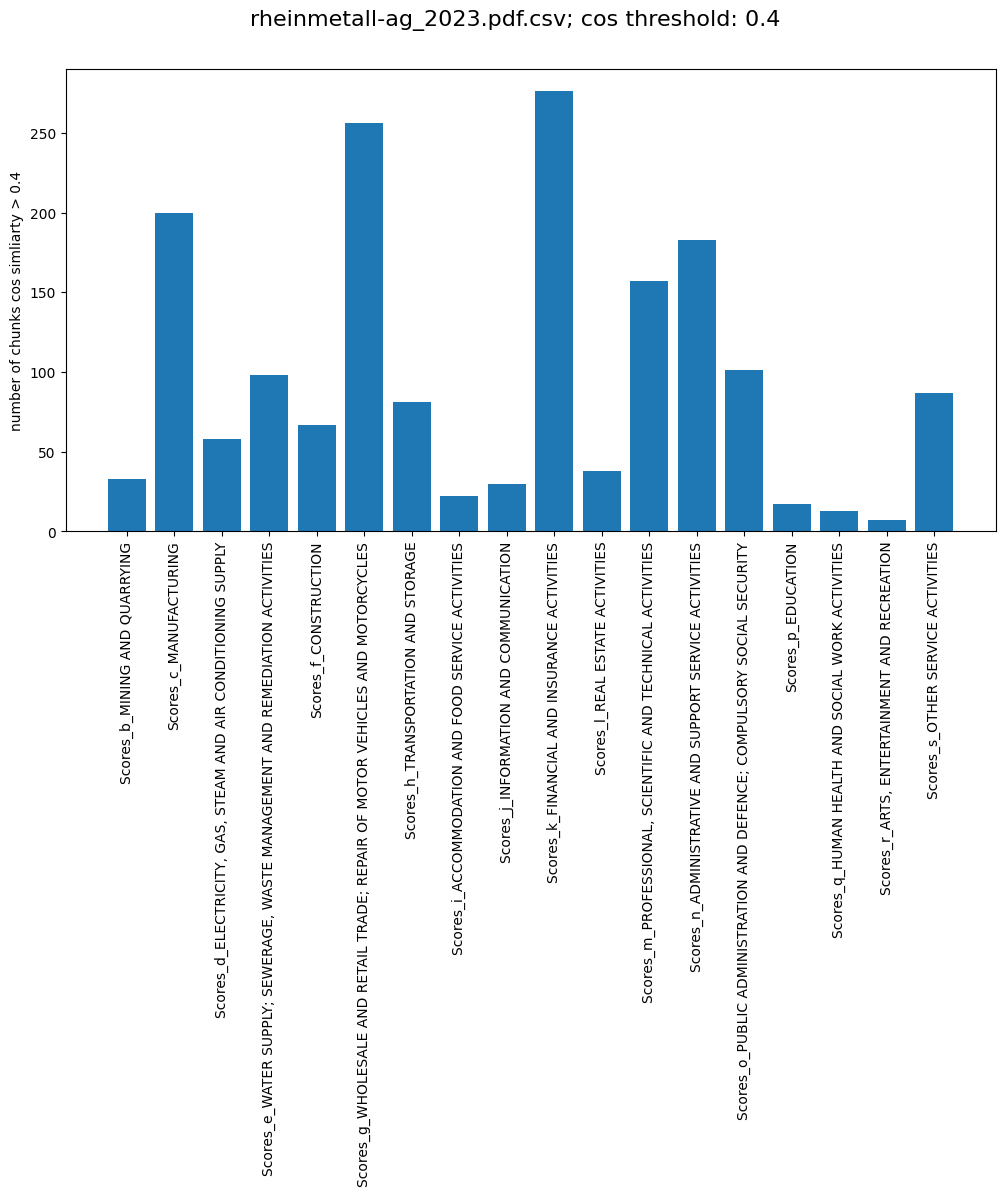

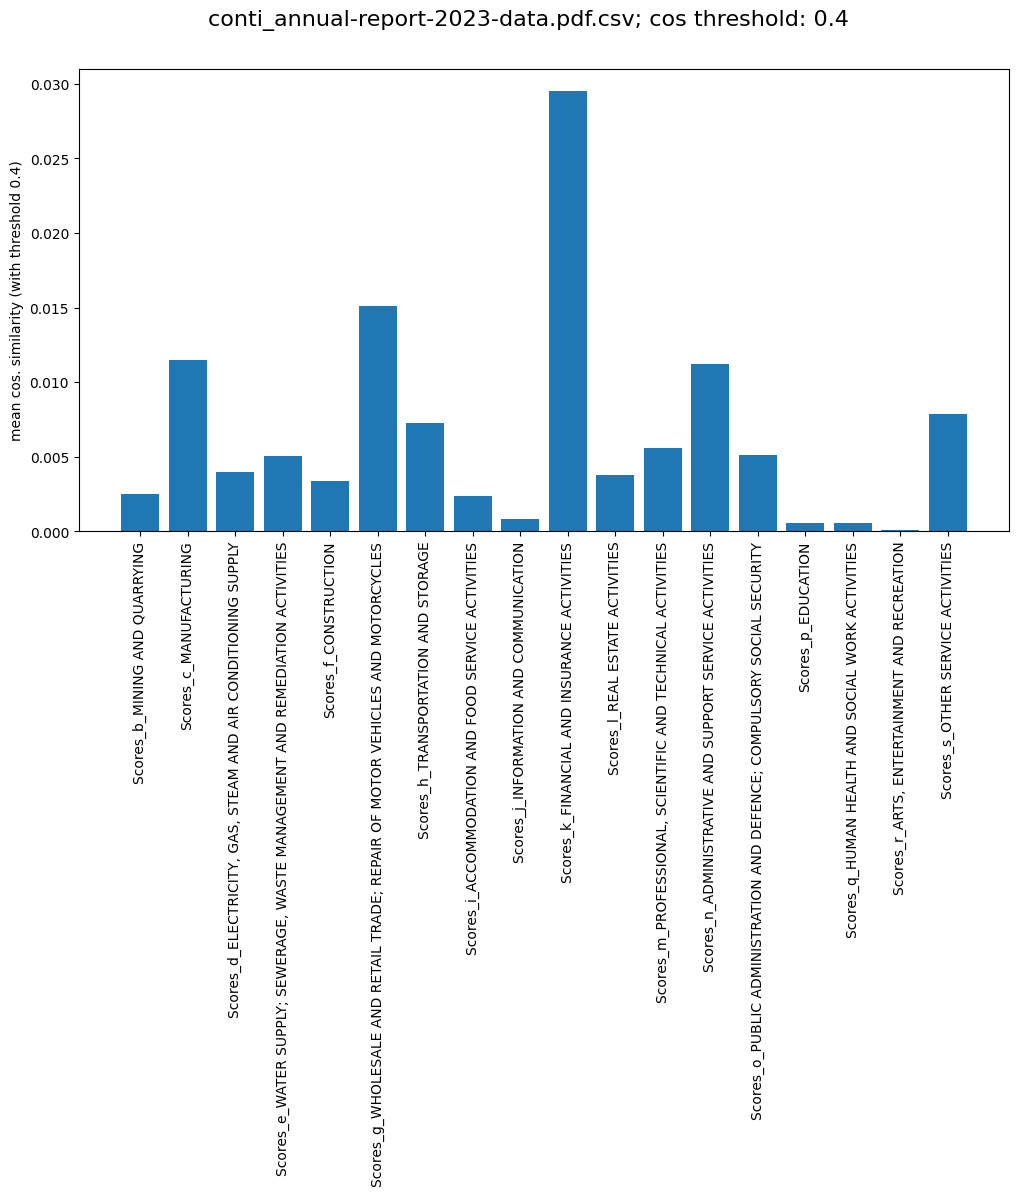

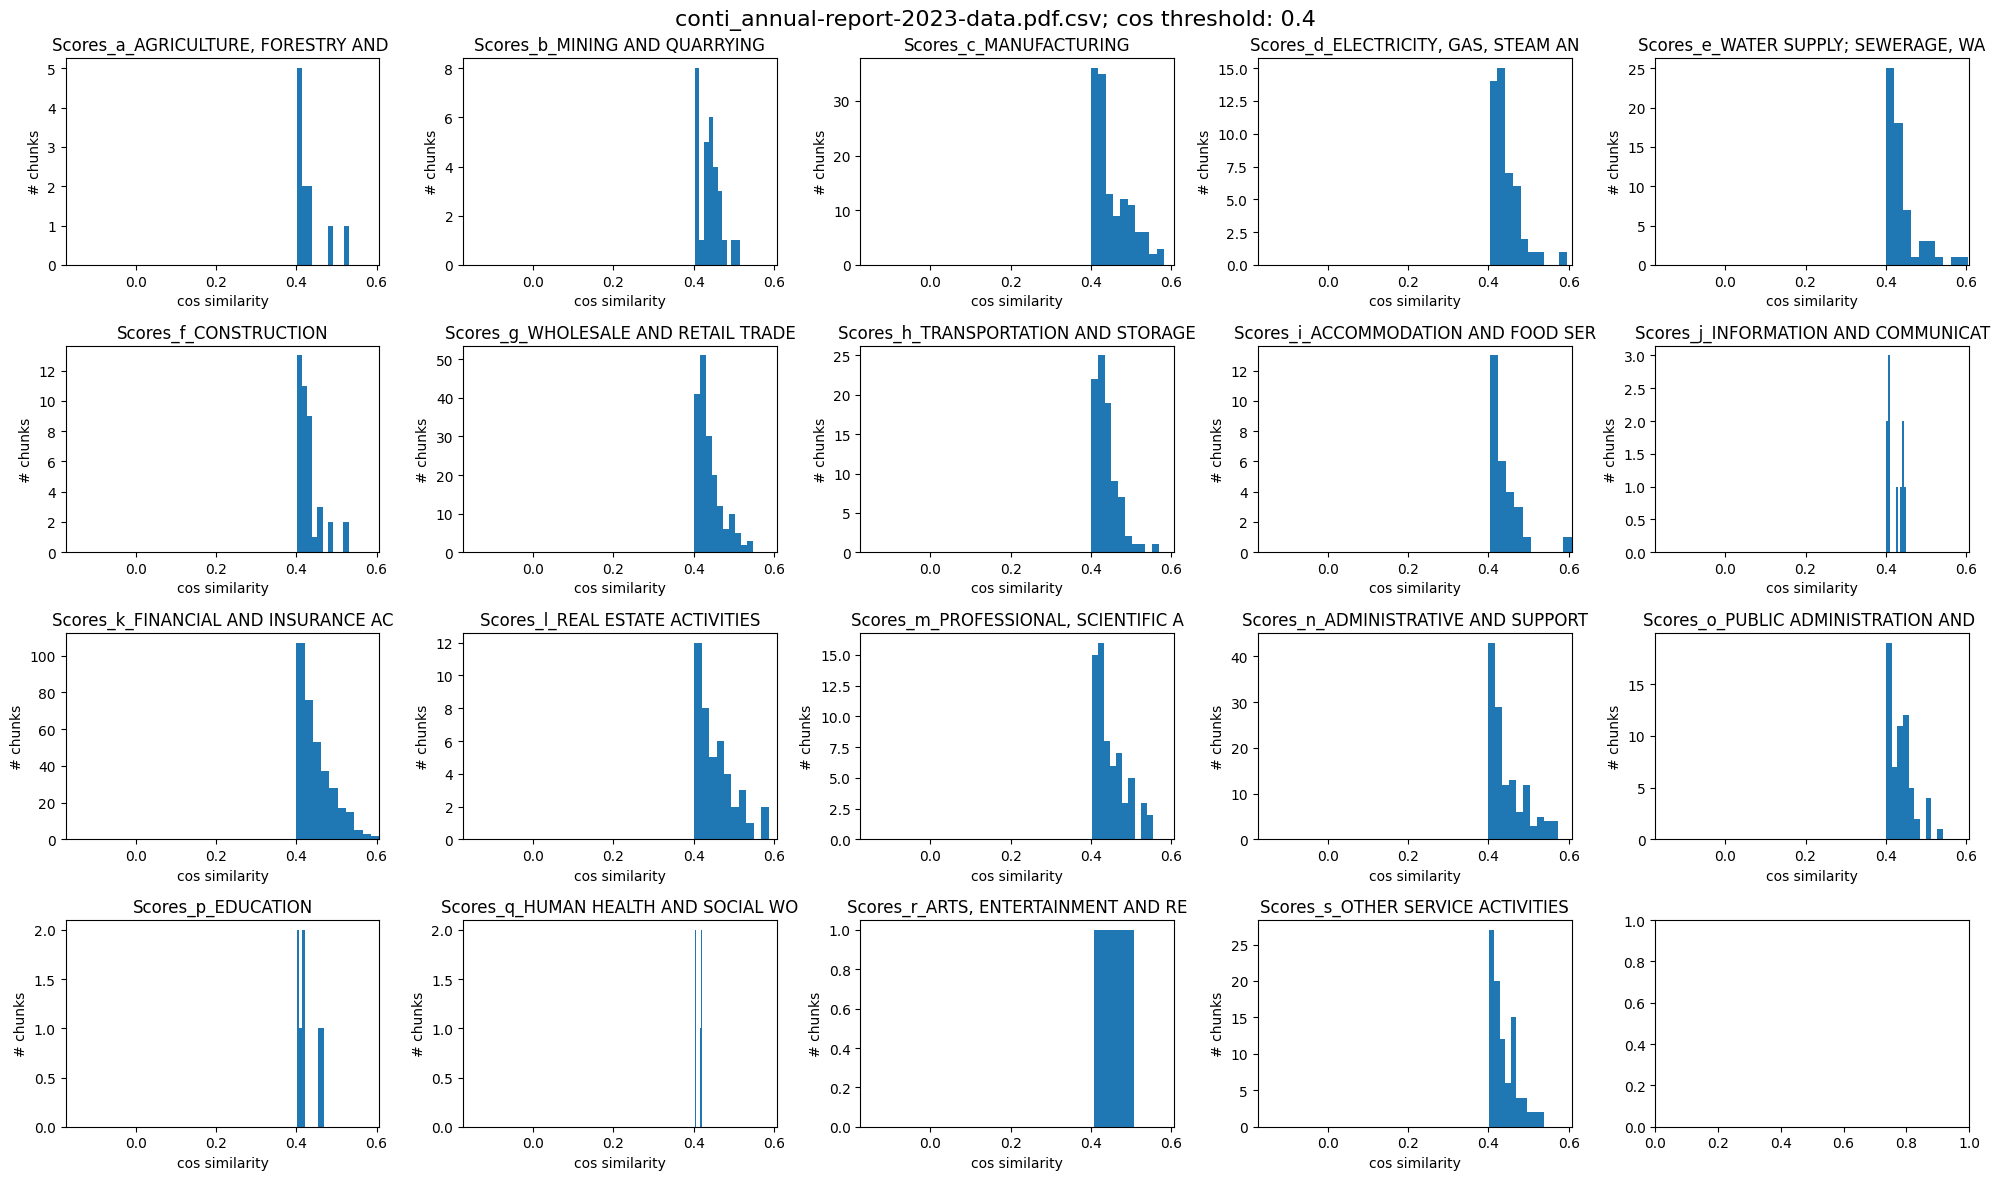

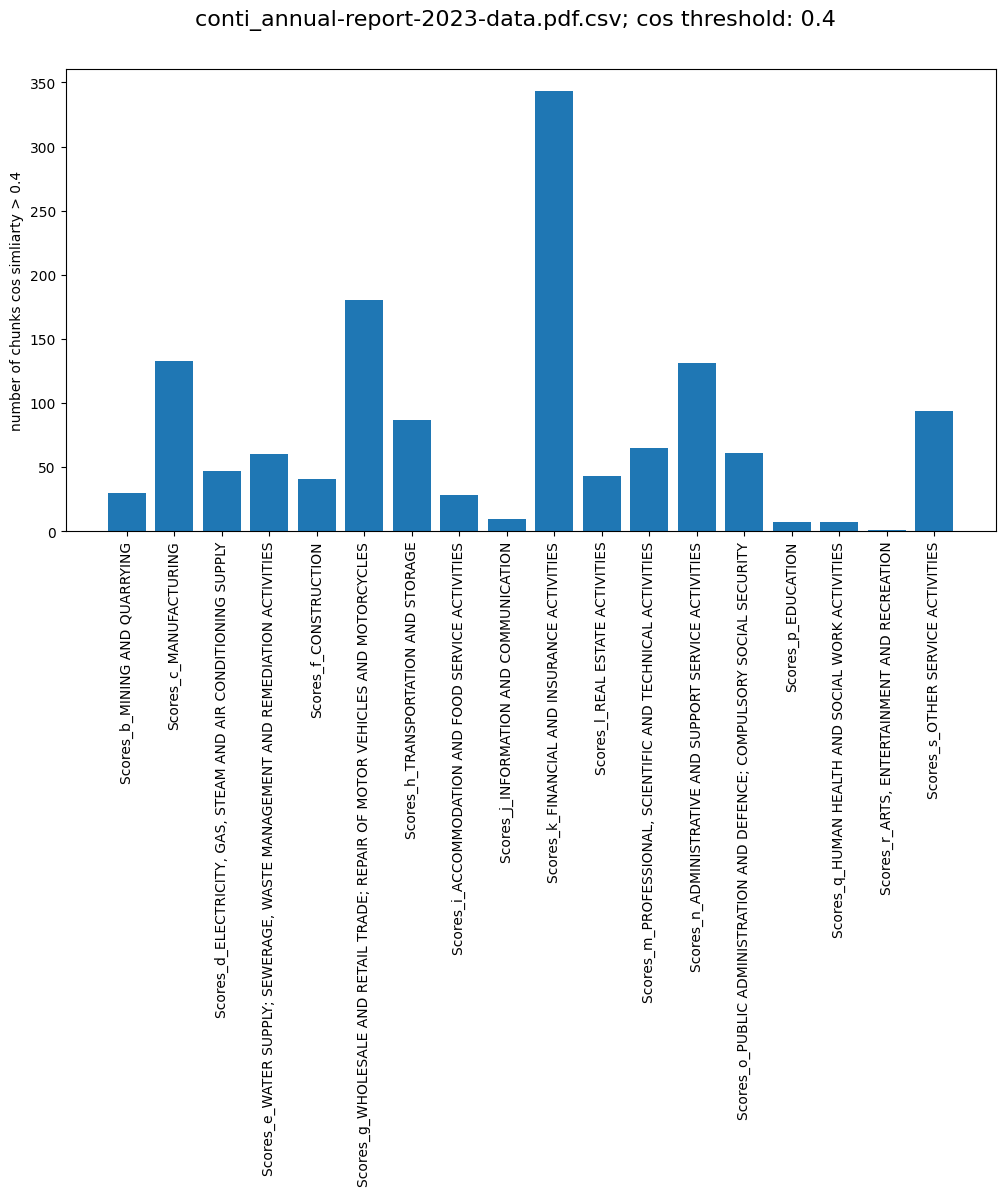

In [ ]:
recording = [] 

for report_path in tqdm.tqdm(reports_path): 

    # retrieve chunks
    chunks = preprocess_report(pdf_path=report_path)

    # get similarities
    df_similarities = create_sentence_nace_code_similarities.create_sentence_nace_code_similarities(chunks)

    # remove irrelevant chunks
    df_similarities = df_similarities[df_similarities["Sentences"].apply(lambda x: len(x)>threshold_min_chunk_len)]

    # plot 
    fig1 = analysis_functions.plot_mean_scores(df_similarities, cos_threshold=cos_threshold, NACE_codes=report_to_nace_class.get(os.path.basename(report_path)), name=os.path.basename(report_path))
    fig2 = analysis_functions.plot_similarity_distributions(df_similarities, cos_threshold=cos_threshold, NACE_codes=report_to_nace_class.get(os.path.basename(report_path)), name=os.path.basename(report_path))
    fig3 = analysis_functions.plot_nbr_threshold(df_similarities, cos_threshold=cos_threshold, NACE_codes=report_to_nace_class.get(os.path.basename(report_path)), name=os.path.basename(report_path))    

    # create report folder 
    os.makedirs(os.path.join(result_path, os.path.basename(report_path)), exist_ok=True)

    # store the figures
    fig1.savefig(os.path.join(result_path, os.path.basename(report_path), "mean_scores.png"), bbox_inches="tight")
    fig2.savefig(os.path.join(result_path, os.path.basename(report_path), "similarity_distributions.png"), bbox_inches="tight")
    fig3.savefig(os.path.join(result_path, os.path.basename(report_path), "nbr_threshold.png"), bbox_inches="tight")

    # remove duplicates
    df_similarities = df_similarities.drop_duplicates(subset=["Sentences"])
    scores = [column for column in df_similarities.columns if "Scores" in column]

    # apply threshold on similarities
    df_temp = df_similarities[scores][df_similarities[scores] > cos_threshold]   
    df_temp = df_temp.fillna(0)
    mean_vals = df_temp.mean().sort_values(ascending=False)

    store_sentences_path = os.path.join(result_path, os.path.basename(report_path), "relevant_sentences_" + os.path.basename(report_path))
    os.makedirs(store_sentences_path, exist_ok=True)

    i = 1
    # store the 100 most important chunks of the 5 most relevant sectors (shown with mean)
    for sector in df_temp.mean().sort_values(ascending=False)[:5].index: 
        top_chunks = df_temp[sector].sort_values(ascending=False)[:100]
        top_chunks_text = "\n\n".join([f"Score {round(df_similarities.loc[idx][sector], 3)}\n"+ df_similarities.loc[idx]["Sentences"] for idx in top_chunks.index])
        top_chunks_text = sector + top_chunks_text

        with open(os.path.join(store_sentences_path, str(i) + "_" + sector + ".txt"), "w") as f:
            f.write(top_chunks_text) 
        i += 1

    df_short = shorten_csv(df_similarities)
    df_short.to_csv(os.path.join(result_path, os.path.basename(report_path), os.path.basename(report_path) + ".csv"))

    mean_vals_dict = {k[7:]:round(v,3) for k,v in mean_vals.to_dict().items()}
    mean_vals_dict
    recording.append({"name": os.path.basename(report_path), "NACE": report_to_nace_class.get(os.path.basename(report_path)),"mean_values": mean_vals_dict})

    df_recording = pd.DataFrame(recording)
    df_recording.to_csv(os.path.join(result_path, "recordings.csv"))

In [ ]:
df_recording

name  NACE  \
0                    Deutsche_Annual-Report-2023.pdf     K   
1                     bayer-annual-report-2023-2.pdf   \tC   
2                                    adidas-ar23.pdf  None   
3  mercedes-benz-annual-report-2023-incl-combined...     C   
4                     Siemens-Annual-Report-2023.pdf   \tC   
5               thyssenkrupp-GB_2023-2024_EN_WEB.pdf     B   
6                         Zalando-SE_DE_241203_s.pdf  None   
7                      heidelberg-materials_2023.pdf     C   
8                            rheinmetall-ag_2023.pdf     C   
9                  conti_annual-report-2023-data.pdf     C   

                                         mean_values  
0  {'k_FINANCIAL AND INSURANCE ACTIVITIES': 0.063...  
1  {'k_FINANCIAL AND INSURANCE ACTIVITIES': 0.021...  
2  {'k_FINANCIAL AND INSURANCE ACTIVITIES': 0.027...  
3  {'k_FINANCIAL AND INSURANCE ACTIVITIES': 0.05,...  
4  {'k_FINANCIAL AND INSURANCE ACTIVITIES': 0.039...  
5  {'k_FINANCIAL AND INSURANCE ACTIVITIES': 0.033...  
6  {'k_FINANCIAL AND INSURANCE ACTIVITIES': 0.023...  
7  {'k_FINANCIAL AND INSURANCE ACTIVITIES': 0.024...  
8  {'k_FINANCIAL AND INSURANCE ACTIVITIES': 0.023...  
9  {'k_FINANCIAL AND INSURANCE ACTIVITIES': 0.029...